# PCA Pairs Trading in the Korea Equities Market

#### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import warnings

#### System Setting

In [2]:
# Prevent Scientific Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Ignore Warning
warnings.filterwarnings('ignore')

## Pickle 로딩 및 데이터 전처리

In [3]:
ticker_series = pd.read_pickle("./pickle/kse_18_20_ticker.pkl")
ticker_series

A005930        삼성전자
A000660      SK하이닉스
A207940    삼성바이오로직스
A035420       NAVER
A068270        셀트리온
             ...   
A005030        부산주공
A019490        하이트론
A109070         컨버즈
A025890        한국주강
A008500        일정실업
Name: 0, Length: 776, dtype: object

In [4]:
sector_df = pd.read_pickle("./pickle/kse_sector.pkl")
sector_df

,A005930,A000660,A207940,A035420,A068270,A051910,A051900,A005380,A006400,A028260,...,A012600,A015260,A000950,A002420,A010580,A019490,A005030,A025890,A109070,A008500
세세분류,통신 및 방송 장비 제조업,"다이오드, 트랜지스터 및 유사 반도체소자 제조업",생물학적 제제 제조업,포털 및 기타 인터넷 정보매개 서비스업,생물학적 제제 제조업,석유화학계 기초 화학물질 제조업,"치약, 비누 및 기타 세제 제조업",승용차 및 기타 여객용 자동차 제조업,축전지 제조업,기타 전문 도매업,...,사무용 기계 및 장비 제조업,인쇄회로기판용 적층판 제조업,면 방적업,영화관 운영업,자동차 엔진용 신품 부품 제조업,영상 및 음향기기 제조업,자동차 엔진용 신품 부품 제조업,특수 목적용 기계 제조업,"골판지, 종이 상자 및 종이 용기 제조업",편조원단 제조업
세분류,통신 및 방송 장비 제조업,"다이오드, 트랜지스터 및 유사 반도체소자 제조업",기초 의약물질 및 생물학적 제제 제조업,포털 및 기타 인터넷 정보매개 서비스업,기초 의약물질 및 생물학적 제제 제조업,기초 유기 화학물질 제조업,"세제, 화장품 및 광택제 제조업",자동차 제조업,일차전지 및 축전지 제조업,기타 전문 도매업,...,사무용 기계 및 장비 제조업,인쇄회로기판 및 전자부품 실장기판 제조업,방적 및 가공사 제조업,영화 및 비디오물 상영업,자동차 엔진용 신품 부품 제조업,영상 및 음향기기 제조업,자동차 엔진용 신품 부품 제조업,특수 목적용 기계 제조업,"골판지, 종이 상자 및 종이 용기 제조업",편조원단 제조업
소분류,통신 및 방송 장비 제조업,반도체 제조업,기초 의약물질 및 생물학적 제제 제조업,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업",기초 의약물질 및 생물학적 제제 제조업,기초 화학물질 제조업,기타 화학제품 제조업,자동차용 엔진 및 자동차 제조업,일차전지 및 축전지 제조업,기타 전문 도매업,...,일반 목적용 기계 제조업,전자부품 제조업,방적 및 가공사 제조업,"영화, 비디오물, 방송프로그램 제작 및 배급업",자동차 신품 부품 제조업,영상 및 음향기기 제조업,자동차 신품 부품 제조업,특수 목적용 기계 제조업,"골판지, 종이 상자 및 종이 용기 제조업",편조원단 제조업
중분류,"전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업","전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업",의료용 물질 및 의약품 제조업,정보서비스업,의료용 물질 및 의약품 제조업,화학물질 및 화학제품 제조업; 의약품 제외,화학물질 및 화학제품 제조업; 의약품 제외,자동차 및 트레일러 제조업,전기장비 제조업,도매 및 상품 중개업,...,기타 기계 및 장비 제조업,"전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업",섬유제품 제조업; 의복제외,영상ㆍ오디오 기록물 제작 및 배급업,자동차 및 트레일러 제조업,"전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업",자동차 및 트레일러 제조업,기타 기계 및 장비 제조업,"펄프, 종이 및 종이제품 제조업",섬유제품 제조업; 의복제외
대분류,제조업,제조업,제조업,"출판, 영상, 방송통신 및 정보서비스업",제조업,제조업,제조업,제조업,제조업,도매 및 소매업,...,제조업,제조업,제조업,"출판, 영상, 방송통신 및 정보서비스업",제조업,제조업,제조업,제조업,제조업,제조업


In [5]:
df_ori = pd.read_pickle("./pickle/kse_18_20.pkl")
# end_date = datetime.datetime(2018, 12, 31)
# target_date = df_ori.index < end_date
# df = df_ori.loc[target_date, :]
df = df_ori
df

Item          수정주가(원)                                                         \
Symbol        A000020   A000040    A000050    A000060     A000070    A000080   
Date                                                                           
2018-01-02  9870.0000 1985.0000 13850.0000 23350.0000 121500.0000 24400.0000   
2018-01-03 10000.0000 1985.0000 13750.0000 23350.0000 123500.0000 24800.0000   
2018-01-04  9750.0000 1985.0000 13750.0000 22700.0000 122000.0000 24550.0000   
2018-01-05  9910.0000 1985.0000 13550.0000 23250.0000 129500.0000 24400.0000   
2018-01-08  9950.0000 1985.0000 13450.0000 23000.0000 129000.0000 23850.0000   
...               ...       ...        ...        ...         ...        ...   
2020-04-29 11250.0000  800.0000 10000.0000 13850.0000  49900.0000 32450.0000   
2020-05-04 10600.0000  821.0000 10000.0000 13550.0000  47750.0000 33000.0000   
2020-05-06 10600.0000  829.0000 10250.0000 13550.0000  48500.0000 34450.0000   
2020-05-07 10400.0000  813.0000 10650.0000 13600.0000  48850.0000 35200.0000   
2020-05-08 10500.0000  808.0000 10500.0000 13750.0000  49350.0000 34200.0000   

Item                                                     ...  \
Symbol        A000100     A000120    A000140    A000150  ...   
Date                                                     ...   
2018-01-02 39758.0000 144000.0000 10000.0000 89408.0000  ...   
2018-01-03 39483.0000 145000.0000 10200.0000 90590.0000  ...   
2018-01-04 38933.0000 145000.0000  9970.0000 93741.0000  ...   
2018-01-05 39849.0000 141500.0000 10050.0000 92559.0000  ...   
2018-01-08 39391.0000 139000.0000 10000.0000 90590.0000  ...   
...               ...         ...        ...        ...  ...   
2020-04-29 47150.0000 148000.0000 13550.0000 40350.0000  ...   
2020-05-04 46350.0000 141500.0000 13950.0000 38500.0000  ...   
2020-05-06 46950.0000 146000.0000 14550.0000 38700.0000  ...   
2020-05-07 46800.0000 145000.0000 14600.0000 38800.0000  ...   
2020-05-08 49150.0000 144000.0000 14250.0000 40100.0000  ...   

Item       시가총액 (52주 평균)(백만원)                                       \
Symbol                A300720     A306200      A307950     A308170   
Date                                                                 
2018-01-02                nan         nan          nan         nan   
2018-01-03                nan         nan          nan         nan   
2018-01-04                nan         nan          nan         nan   
2018-01-05                nan         nan          nan         nan   
2018-01-08                nan         nan          nan         nan   
...                       ...         ...          ...         ...   
2020-04-29        413696.0000 166189.0000 1058142.0000 229615.0000   
2020-05-04        411026.0000 165782.0000 1050367.0000 229956.0000   
2020-05-06        410814.0000 165569.0000 1049579.0000 230335.0000   
2020-05-07        409844.0000 165293.0000 1046935.0000 230698.0000   
2020-05-08        408879.0000 165042.0000 1044023.0000 231063.0000   

Item                                                                     \
Symbol          A316140     A317400     A322000     A336260     A336370   
Date                                                                      
2018-01-02          nan         nan         nan         nan         nan   
2018-01-03          nan         nan         nan         nan         nan   
2018-01-04          nan         nan         nan         nan         nan   
2018-01-05          nan         nan         nan         nan         nan   
2018-01-08          nan         nan         nan         nan         nan   
...                 ...         ...         ...         ...         ...   
2020-04-29 8107363.0000 141844.0000 216559.0000 498447.0000 792601.0000   
2020-05-04 8080639.0000 141676.0000 216555.0000 498238.0000 795023.0000   
2020-05-06 8071493.0000 141526.0000 216616.0000 498039.0000 797393.0000   
2020-05-07 8056255.0000 141417.0000 216725.0000 497894.0000 799929.0000   
2020-05-08 8041163.0000 14

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 576 entries, 2018-01-02 to 2020-05-08
Columns: 1552 entries, (수정주가(원), A000020) to (시가총액 (52주 평균)(백만원), A344820)
dtypes: float64(1552)
memory usage: 6.8 MB


In [7]:
df.describe()

Item      수정주가(원)                                                         \
Symbol    A000020   A000040    A000050    A000060     A000070    A000080   
count    576.0000  576.0000   576.0000   576.0000    576.0000   576.0000   
mean    9586.7101 2000.8021 11439.2535 19700.1389  83041.4931 22017.9688   
std     1528.8402  586.8013  1871.6443  3050.1847  22642.3957  4675.7555   
min     4985.0000  441.0000  6850.0000  9180.0000  32500.0000 15300.0000   
25%     8247.5000 1989.0000  9980.0000 18387.5000  64200.0000 17987.5000   
50%     9645.0000 2113.0000 11000.0000 19600.0000  82650.0000 21100.0000   
75%    10650.0000 2340.0000 13350.0000 22000.0000 102000.0000 26237.5000   
max    13150.0000 3069.0000 15900.0000 25600.0000 145500.0000 35200.0000   

Item                                                  ... 시가총액 (52주 평균)(백만원)  \
Symbol    A000100     A000120    A000140     A000150  ...            A300720   
count    576.0000    576.0000   576.0000    576.0000  ...           430.0000   
mean   43266.2361 151208.3333  9834.0625  79145.5365  ...        527951.9023   
std     2984.1892  13803.2447  2121.8487  15400.0195  ...         43257.5576   
min    30688.0000 118500.0000  6460.0000  26050.0000  ...        408879.0000   
25%    41315.0000 140500.0000  8077.5000  74485.2500  ...        500417.0000   
50%    43239.0000 151500.0000  9470.0000  80349.0000  ...        544956.5000   
75%    45517.0000 159500.0000 11050.0000  87143.5000  ...        558720.7500   
max    50834.0000 190500.0000 15450.0000 112646.0000  ...        592579.0000   

Item                                                                   \
Symbol     A306200      A307950     A308170       A316140     A317400   
count     391.0000     275.0000    111.0000      305.0000    124.0000   
mean   179656.6624 1353183.4945 184898.0360  9330561.1639 154495.8548   
std      5039.3779  190565.9877  45085.6569   557411.2762   5917.0647   
min    165042.0000 1044023.0000  83496.0000  8041163.0000 141383.0000   
25%    177449.5000 1218037.0000 133189.0000  9030086.0000 151806.5000   
50%    180002.0000 1299786.0000 208806.0000  9279130.0000 157008.5000   
75%    182306.5000 1480506.0000 225442.0000  9710450.0000 158557.0000   
max    207050.0000 1862700.0000 231063.0000 10661576.0000 163909.0000   

Item                                                    
Symbol     A322000     A336260     A336370     A344820  
count     115.0000    137.0000    137.0000     73.0000  
mean   194660.1478 523058.6861 669622.7956 282103.0685  
std     19100.1501  22255.2432 114279.6029  54846.9989  
min    164360.0000 374580.0000 206470.0000 226602.0000  
25%    177529.0000 508369.0000 627693.0000 230686.0000  
50%    193760.0000 533310.0000 693269.0000 273413.0000  
75%    214613.0000 538526.0000 754571.0000 317440.0000  
max    216993.0000 542996.0000 802487.0000 465942.0000  

[8 rows x 1552 columns]

In [8]:
df = df.dropna(axis=1)
df

Item          수정주가(원)                                                         \
Symbol        A000020   A000040    A000050    A000060     A000070    A000080   
Date                                                                           
2018-01-02  9870.0000 1985.0000 13850.0000 23350.0000 121500.0000 24400.0000   
2018-01-03 10000.0000 1985.0000 13750.0000 23350.0000 123500.0000 24800.0000   
2018-01-04  9750.0000 1985.0000 13750.0000 22700.0000 122000.0000 24550.0000   
2018-01-05  9910.0000 1985.0000 13550.0000 23250.0000 129500.0000 24400.0000   
2018-01-08  9950.0000 1985.0000 13450.0000 23000.0000 129000.0000 23850.0000   
...               ...       ...        ...        ...         ...        ...   
2020-04-29 11250.0000  800.0000 10000.0000 13850.0000  49900.0000 32450.0000   
2020-05-04 10600.0000  821.0000 10000.0000 13550.0000  47750.0000 33000.0000   
2020-05-06 10600.0000  829.0000 10250.0000 13550.0000  48500.0000 34450.0000   
2020-05-07 10400.0000  813.0000 10650.0000 13600.0000  48850.0000 35200.0000   
2020-05-08 10500.0000  808.0000 10500.0000 13750.0000  49350.0000 34200.0000   

Item                                                     ...  \
Symbol        A000100     A000120    A000140    A000150  ...   
Date                                                     ...   
2018-01-02 39758.0000 144000.0000 10000.0000 89408.0000  ...   
2018-01-03 39483.0000 145000.0000 10200.0000 90590.0000  ...   
2018-01-04 38933.0000 145000.0000  9970.0000 93741.0000  ...   
2018-01-05 39849.0000 141500.0000 10050.0000 92559.0000  ...   
2018-01-08 39391.0000 139000.0000 10000.0000 90590.0000  ...   
...               ...         ...        ...        ...  ...   
2020-04-29 47150.0000 148000.0000 13550.0000 40350.0000  ...   
2020-05-04 46350.0000 141500.0000 13950.0000 38500.0000  ...   
2020-05-06 46950.0000 146000.0000 14550.0000 38700.0000  ...   
2020-05-07 46800.0000 145000.0000 14600.0000 38800.0000  ...   
2020-05-08 49150.0000 144000.0000 14250.0000 40100.0000  ...   

Item       시가총액 (52주 평균)(백만원)                                       \
Symbol                A267290     A268280      A271560     A271980   
Date                                                                 
2018-01-02        163383.0000 308852.0000 3945008.0000 659044.0000   
2018-01-03        163424.0000 308799.0000 3946407.0000 659310.0000   
2018-01-04        163466.0000 308761.0000 3946794.0000 659562.0000   
2018-01-05        163510.0000 308734.0000 3947338.0000 659929.0000   
2018-01-08        163552.0000 308697.0000 3948360.0000 660280.0000   
...                       ...         ...          ...         ...   
2020-04-29        124605.0000 382251.0000 3931310.0000 475492.0000   
2020-05-04        123908.0000 382164.0000 3935677.0000 473234.0000   
2020-05-06        123848.0000 382268.0000 3939511.0000 472902.0000   
2020-05-07        123601.0000 382310.0000 3943833.0000 472065.0000   
2020-05-08        123365.0000 382352.0000 3947355.0000 471252.0000   

Item                                                                     \
Symbol         A272450     A272550     A280360     A281820      A282330   
Date                                                                      
2018-01-02 806800.0000 299213.0000 667430.0000 449747.0000 3877932.0000   
2018-01-03 808406.0000 299518.0000 666768.0000 447743.0000 3854311.0000   
2018-01-04 809559.0000 300004.0000 666273.0000 445443.0000 3831435.0000   
2018-01-05 810833.0000 300623.0000 665755.0000 443551.0000 3810621.0000   
2018-01-08 811105.0000 300865.0000 665170.0000 441380.0000 3791088.0000   
...                ...         ...         ...         ...          ...   
2020-04-29 466541.0000 232476.0000 946740.0000 355640.0000 3099534.0000   
2020-05-04 462407.0000 232258.0000 943247.0000 355245.0000 3090095.0000   
2020-05-06 461774.0000 232273.0000 942792.0000 355301.0000 3088746.0000   
2020-05-07 459952.0000 232258.0000 941390.0000 355269.0000 3085072.0000   
2020-05-08 458191.0000 232

In [9]:
df_price = df['수정주가(원)']
df_price

Symbol,A000020,A000040,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,...,A267290,A268280,A271560,A271980,A272450,A272550,A280360,A281820,A282330,A282690
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,9870.0000,1985.0000,13850.0000,23350.0000,121500.0000,24400.0000,39758.0000,144000.0000,10000.0000,89408.0000,...,28587.0000,57600.0000,107000.0000,46522.0000,27650.0000,20450.0000,147000.0000,20700.0000,210500.0000,10300.0000
2018-01-03,10000.0000,1985.0000,13750.0000,23350.0000,123500.0000,24800.0000,39483.0000,145000.0000,10200.0000,90590.0000,...,28827.0000,58100.0000,104000.0000,46879.0000,27750.0000,21550.0000,151500.0000,20750.0000,202500.0000,11150.0000
2018-01-04,9750.0000,1985.0000,13750.0000,22700.0000,122000.0000,24550.0000,38933.0000,145000.0000,9970.0000,93741.0000,...,28867.0000,58500.0000,101000.0000,46808.0000,27600.0000,21900.0000,153000.0000,20250.0000,200500.0000,11150.0000
2018-01-05,9910.0000,1985.0000,13550.0000,23250.0000,129500.0000,24400.0000,39849.0000,141500.0000,10050.0000,92559.0000,...,28947.0000,58800.0000,101500.0000,47737.0000,27750.0000,22200.0000,152500.0000,20450.0000,200000.0000,11150.0000
2018-01-08,9950.0000,1985.0000,13450.0000,23000.0000,129000.0000,23850.0000,39391.0000,139000.0000,10000.0000,90590.0000,...,28907.0000,58500.0000,103000.0000,47666.0000,27200.0000,21600.0000,151500.0000,19950.0000,199000.0000,10900.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-29,11250.0000,800.0000,10000.0000,13850.0000,49900.0000,32450.0000,47150.0000,148000.0000,13550.0000,40350.0000,...,17750.0000,76200.0000,124000.0000,26350.0000,10850.0000,16500.0000,128000.0000,18050.0000,158000.0000,11100.0000
2020-05-04,10600.0000,821.0000,10000.0000,13550.0000,47750.0000,33000.0000,46350.0000,141500.0000,13950.0000,38500.0000,...,18050.0000,77000.0000,121000.0000,25650.0000,10450.0000,16650.0000,124000.0000,17850.0000,153500.0000,11200.0000
2020-05-06,10600.0000,829.0000,10250.0000,13550.0000,48500.0000,34450.0000,46950.0000,146000.0000,14550.0000,38700.0000,...,18500.0000,77400.0000,123500.0000,26600.0000,10200.0000,16600.0000,129500.0000,18600.0000,159500.0000,11250.0000


## Split Formation period and Trading period

In [10]:
form_str_date = datetime.datetime(2018, 1, 1)
form_end_date = datetime.datetime(2018, 12, 31)
trading_str_date = datetime.datetime(2019, 1, 1)
trading_end_date = datetime.datetime(2019, 6, 30)

In [11]:
formation_close = df_price[form_str_date:form_end_date]
trading_close = df_price[trading_str_date:trading_end_date]
formation_close

Symbol,A000020,A000040,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,...,A267290,A268280,A271560,A271980,A272450,A272550,A280360,A281820,A282330,A282690
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,9870.0000,1985.0000,13850.0000,23350.0000,121500.0000,24400.0000,39758.0000,144000.0000,10000.0000,89408.0000,...,28587.0000,57600.0000,107000.0000,46522.0000,27650.0000,20450.0000,147000.0000,20700.0000,210500.0000,10300.0000
2018-01-03,10000.0000,1985.0000,13750.0000,23350.0000,123500.0000,24800.0000,39483.0000,145000.0000,10200.0000,90590.0000,...,28827.0000,58100.0000,104000.0000,46879.0000,27750.0000,21550.0000,151500.0000,20750.0000,202500.0000,11150.0000
2018-01-04,9750.0000,1985.0000,13750.0000,22700.0000,122000.0000,24550.0000,38933.0000,145000.0000,9970.0000,93741.0000,...,28867.0000,58500.0000,101000.0000,46808.0000,27600.0000,21900.0000,153000.0000,20250.0000,200500.0000,11150.0000
2018-01-05,9910.0000,1985.0000,13550.0000,23250.0000,129500.0000,24400.0000,39849.0000,141500.0000,10050.0000,92559.0000,...,28947.0000,58800.0000,101500.0000,47737.0000,27750.0000,22200.0000,152500.0000,20450.0000,200000.0000,11150.0000
2018-01-08,9950.0000,1985.0000,13450.0000,23000.0000,129000.0000,23850.0000,39391.0000,139000.0000,10000.0000,90590.0000,...,28907.0000,58500.0000,103000.0000,47666.0000,27200.0000,21600.0000,151500.0000,19950.0000,199000.0000,10900.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,9030.0000,2091.0000,10950.0000,21900.0000,81200.0000,18000.0000,40216.0000,170500.0000,7000.0000,94528.0000,...,26785.0000,64300.0000,117500.0000,44400.0000,19400.0000,17350.0000,162500.0000,9330.0000,218000.0000,12850.0000
2018-12-24,8830.0000,2062.0000,11100.0000,21700.0000,80400.0000,17750.0000,40307.0000,167000.0000,7100.0000,90983.0000,...,26985.0000,64000.0000,117500.0000,44250.0000,18950.0000,17450.0000,159500.0000,9470.0000,210500.0000,12900.0000
2018-12-26,8730.0000,2062.0000,10850.0000,21950.0000,79000.0000,17550.0000,40399.0000,165000.0000,6920.0000,87439.0000,...,26705.0000,64200.0000,115000.0000,42200.0000,18500.0000,16950.0000,156000.0000,9290.0000,210000.0000,12500.0000


In [12]:
trading_close

Symbol,A000020,A000040,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,...,A267290,A268280,A271560,A271980,A272450,A272550,A280360,A281820,A282330,A282690
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,9340.0000,2030.0000,10950.0000,21350.0000,78200.0000,16300.0000,40016.0000,166500.0000,7030.0000,82318.0000,...,26585.0000,64100.0000,111000.0000,44400.0000,19000.0000,17950.0000,153000.0000,9470.0000,205500.0000,12700.0000
2019-01-03,9170.0000,2042.0000,11150.0000,20900.0000,77200.0000,16200.0000,39346.0000,163000.0000,7020.0000,79561.0000,...,26585.0000,64600.0000,118000.0000,44250.0000,18550.0000,18300.0000,156500.0000,9170.0000,209500.0000,12900.0000
2019-01-04,9530.0000,2042.0000,11000.0000,21700.0000,79700.0000,16850.0000,42122.0000,163500.0000,7020.0000,78774.0000,...,26585.0000,64800.0000,121500.0000,52300.0000,18200.0000,18800.0000,162500.0000,9090.0000,214000.0000,12750.0000
2019-01-07,9530.0000,2046.0000,11100.0000,22000.0000,82100.0000,16750.0000,43654.0000,162000.0000,7390.0000,81137.0000,...,26305.0000,65300.0000,122500.0000,50800.0000,18250.0000,18650.0000,169500.0000,9470.0000,207500.0000,12900.0000
2019-01-08,9520.0000,2058.0000,11000.0000,22450.0000,81000.0000,16600.0000,44037.0000,161500.0000,7680.0000,81925.0000,...,26425.0000,64700.0000,123000.0000,48300.0000,18200.0000,18650.0000,164500.0000,9750.0000,205500.0000,12800.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,9880.0000,2127.0000,10500.0000,21050.0000,75000.0000,20700.0000,47579.0000,153000.0000,9160.0000,80743.0000,...,24983.0000,76500.0000,91200.0000,39000.0000,22450.0000,17550.0000,172000.0000,14800.0000,198000.0000,13350.0000
2019-06-25,9860.0000,2164.0000,10550.0000,20600.0000,74000.0000,21000.0000,46717.0000,144500.0000,9250.0000,81137.0000,...,24583.0000,76900.0000,92100.0000,39100.0000,21550.0000,17550.0000,174000.0000,14750.0000,192000.0000,13450.0000
2019-06-26,9840.0000,2201.0000,10500.0000,20650.0000,73400.0000,20850.0000,47291.0000,133000.0000,9240.0000,79955.0000,...,24583.0000,77900.0000,91500.0000,38700.0000,20950.0000,17550.0000,174500.0000,15200.0000,194000.0000,13550.0000


## Finding Pairs

In [28]:
def finding_pairs(df_p):
    # Normalization
    df_return = df_p.pct_change()
    df_return = df_return.dropna(axis=0)
    # scaler = StandardScaler()
    # df_return = pd.DataFrame(scaler.fit_transform(df_return))
    
    for col in df_return.columns:
        df_return[col] = (df_return[col] - df_return[col].mean()) / df_return[col].std()
    
    # PCA on return space
    pca = PCA()
    pca.fit(df_return)
    return_pca = pca.transform(df_return)
    
    # Eigen portfolio returns
    df_eig = pd.DataFrame()
    eig_lim = 5
    for i in range(eig_lim):
        df_eig[i] = df_return.mul(pca.components_[i], axis=1).sum(axis=1)
    
    # regression (X: Eigen portfolios(Risk Factor from PCA), Y: Individual Return)
    df_reg = df_eig.copy()
    df_reg = sm.add_constant(df_reg)
    
    # Factor Loading estimation(OLS) for each stocks
    df_params = pd.DataFrame()
    df_pval = pd.DataFrame()
    for ticker in df_return.columns:
        results = sm.OLS(df_return.loc[:,ticker] ,df_reg).fit()
        df_params[ticker] = results.params
        df_pval[ticker] = results.pvalues
    
    df_params = df_params.T
    df_pval = df_pval.T
    
    # First Clustering: Grouping stocks which have same confident factors
    pval_thr = 0.05
    df_pval_bool = df_pval < pval_thr
    
    def classify_duplicate(df):
        df_c = df.copy()
        df_list = []
        df_non = pd.DataFrame()
        idx_list = df.index
        for idx in idx_list:
            if idx not in df_c.index:
                continue
            # print(idx)
            temp_df = pd.DataFrame()
            # temp_df[idx] = df_c.loc[idx,:]
            temp_series = df_c.loc[idx, :]
            df_c = df_c.drop(idx)
            cnt = 0
            for idx2 in df_c.index:
                if (temp_series == df_c.loc[idx2, :]).all():
                    # print(idx, idx2)
                    temp_df[idx2] = df_c.loc[idx2, :]
                    df_c = df_c.drop(idx2)
                    cnt += 1
            if cnt == 0:
                df_non[idx] = temp_series
            else:
                temp_df[idx] = temp_series
                df_list.append(temp_df.T)
        return df_list, df_non.T

    classified_list, df_nc = classify_duplicate(df_pval_bool)
    
    # Second Clustering: Grouping stocks which have similar factor loadings
    for d in classified_list[:10]:
        target_tickers = d.index
        factor_sig = d.iloc[0,:]
        k = factor_sig.sum()
    
        kmeans_pca = KMeans(n_clusters = k, init = 'k-means++', random_state=1)
        kmeans_pca.fit(df_params.loc[target_tickers, factor_sig])
        d['cluster'] = kmeans_pca.labels_
        
    # target_c = classified_list[0]
    # stocks = target_c.index[target_c['cluster'] == 0]
    # pvals, pairs = find_cointegrated_pairs_adf(df_price.loc[:, stocks])
    # df_pairs = pd.DataFrame(pairs, columns=['s1', 's2', 'pval', 'beta', 'alpha'])
    # df_pairs = df_pairs.sort_index(by='pval').reset_index(drop=True)
    
    df_pairs_total = pd.DataFrame(columns=['s1', 's2', 'pval', 'beta', 'alpha', 'cluster'])
    for i, c1 in enumerate(classified_list):
        if len(c1) < 3:
            continue
        if 'cluster' not in c1.columns:
            # Not Clustered stocks in first clustering step
            continue
        df_pairs_semi = pd.DataFrame(columns=['s1', 's2', 'pval', 'beta', 'alpha', 'cluster'])
        print("Finding Pairs from {} Cluster({} stocks in the cluster)..".format(i, len(c1)))
        for c2 in c1['cluster'].unique():
            print("\tFinding Pairs from {} Small Cluster".format(c2))
            stocks = c1.index[c1['cluster'] == c2]
            # _, pairs = find_cointegrated_pairs_adf(df_p.loc[:, stocks])
            _, pairs = find_cointegrated_pairs_adf((df_return+1).loc[:, stocks].cumprod())
            df_pairs = pd.DataFrame(pairs, columns=['s1', 's2', 'pval', 'beta', 'alpha', 'r2'])
            df_pairs = df_pairs.sort_values(by='pval').reset_index(drop=True)
            df_pairs['cluster'] = str(i) + '_' + str(c2)
            df_pairs_semi = df_pairs_semi.append(df_pairs, ignore_index=True)
        # Select Top n Pairs from each Clusters
        r2_high_thr =1
        r2_low_thr = 0.75
        # r2_thr = 0.9
        df_pairs_semi = df_pairs_semi.loc[df_pairs_semi['r2'] > r2_low_thr, :]
        df_pairs_semi = df_pairs_semi.loc[df_pairs_semi['r2'] < r2_high_thr, :]
        top_n = 5
        if len(df_pairs_semi) > top_n:
            df_pairs_semi = df_pairs_semi[:top_n]
        df_pairs_total = df_pairs_total.append(df_pairs_semi, ignore_index=True)            
    
    return df_pairs_total


In [22]:
def adf_coint_test(df1, df2):
    df2_temp = df2.copy()
    # df2_temp = sm.add_constant(df2_temp)
    results = sm.OLS(df1, df2_temp).fit()
    coint_pval= adfuller(results.resid)[1]
    # alpha = results.params[0]
    # beta = results.params[1]
    alpha = 0
    beta = results.params[0]
    r2 = results.rsquared
    
    return coint_pval, beta, alpha, r2

In [23]:
def find_cointegrated_pairs_adf(dataframe, critial_level=0.02):
    n = dataframe.shape[1]  # the length of dateframe
    pvalue_matrix = np.ones((n, n))  # initialize the matrix of p
    keys = dataframe.keys()  # get the column names
    pairs = []  # initilize the list for cointegration
    for i in range(n):
        for j in range(i + 1, n):  # for j bigger than i
            # stock1 = np.log(dataframe[keys[i]])  # obtain the price of two contract
            # stock2 = np.log(dataframe[keys[j]])
            stock1 = dataframe[keys[i]]  # obtain the price of two contract
            stock2 = dataframe[keys[j]]
            pval, beta, alpha, r2 = adf_coint_test(stock1, stock2)  # get conintegration
            pvalue_matrix[i, j] = pval
            if pval < critial_level:  # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pval, beta, alpha, r2))  # record the contract with that p-value

    return pvalue_matrix, pairs

In [29]:
df_pairs_t = finding_pairs(formation_close)
df_pairs_t

Finding Pairs from 0 Cluster(74 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 1 Cluster(26 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 2 Cluster(14 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 3 Cluster(12 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 3 Small Cluster
Finding Pairs from 4 Cluster(44 stocks in the cluster)..
	Finding Pairs from 4 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 3 Small Cluster
Finding Pairs from 5 Cluster(59 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding P

,alpha,beta,cluster,pval,r2,s1,s2
0,0,0.2523,0_2,0.0000,0.9755,A049770,A084690
1,0,0.3507,0_2,0.0000,0.8306,A049770,A204320
2,0,0.8301,0_1,0.0000,0.8356,A004710,A000020
3,0,0.2966,0_1,0.0000,0.7587,A002620,A055490
4,0,4.9350,0_1,0.0000,0.8465,A004710,A020150
5,0,2.7936,1_0,0.0001,0.7546,A004560,A007590
6,0,0.2099,1_2,0.0000,0.8347,A017810,A073240
7,0,1.8963,2_1,0.0000,0.9001,A003570,A114090
8,0,-0.3139,3_1,0.0000,0.9888,A005850,A027410
9,0,0.6296,4_2,0.0000,0.7609,A004490,A060980


In [26]:
def draw_pairs(df_pairs, df_p):
    # font_path = 'C:/Windows/Fonts/H2GTRM.TTF'
    # fontprop = FontProperties(fname=font_path, size=15)
    for i in df_pairs.index:
        s1_code = df_return[df_pairs.loc[i, 's1']].name
        s2_code = df_return[df_pairs.loc[i, 's2']].name
        s1_name = s1_code # ticker_series[s1_code]
        s2_name = s2_code # ticker_series[s2_code]
        
        logp1 = (df_return[df_pairs.loc[i, 's1']])
        logp2 = (df_return[df_pairs.loc[i, 's2']])
        a = df_pairs.loc[i, 'alpha']
        b = df_pairs.loc[i, 'beta']

        pd.Series(logp1).plot(label=s1_name)
        pd.Series(logp2 * b + a).plot(label=s2_name)
        print('{}th'.format(i))
        print(df_pairs.loc[i, 'cluster'])
        print(df_pairs.loc[i, 'pval'])
        print('R2: ' + str(df_pairs.loc[i, 'r2']))
        
        
        plt.legend()
        plt.show()
        plt.close()

In [19]:
def draw_pairs1(df_pairs, df_p):
    # font_path = 'C:/Windows/Fonts/H2GTRM.TTF'
    # fontprop = FontProperties(fname=font_path, size=15)
    for i in df_pairs.index:
        s1_code = df_p[df_pairs.loc[i, 's1']].name
        s2_code = df_p[df_pairs.loc[i, 's2']].name
        s1_name = s1_code # ticker_series[s1_code]
        s2_name = s2_code # ticker_series[s2_code]
        
        logp1 = (df_p[df_pairs.loc[i, 's1']])
        logp2 = (df_p[df_pairs.loc[i, 's2']])
        a = df_pairs.loc[i, 'alpha']
        b = df_pairs.loc[i, 'beta']

        pd.Series(logp1 - logp2).plot()
        print('{}th'.format(i))
        print(df_pairs.loc[i, 'cluster'])
        print(df_pairs.loc[i, 'pval'])
        print('R2: ' + str(df_pairs.loc[i, 'r2']))
        
        
        plt.legend()
        plt.show()
        plt.close()

In [27]:
draw_pairs(df_pairs_t, formation_close)

NameError: name 'df_return' is not defined

0th
0_2
0.0001595379318461604
R2: 0.9925312993787521


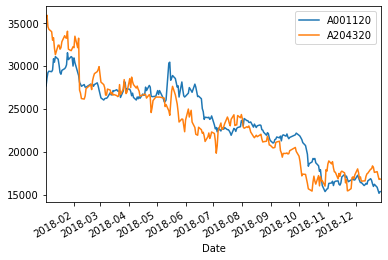

1th
0_2
0.00108707139395254
R2: 0.9868544179250036


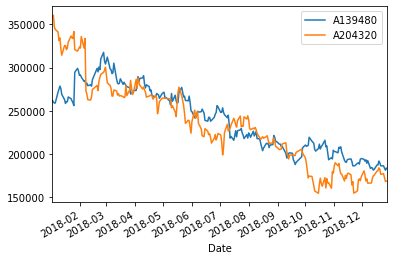

2th
0_2
0.001639852325484842
R2: 0.9987018288858769


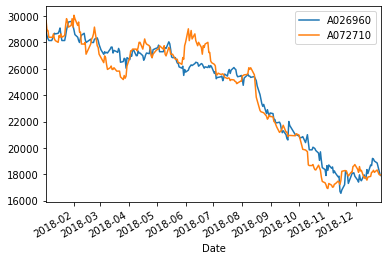

3th
0_2
0.00356745651597601
R2: 0.9871566362513677


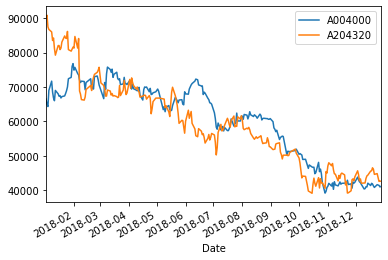

4th
0_2
0.009607186336737523
R2: 0.9883548598160425


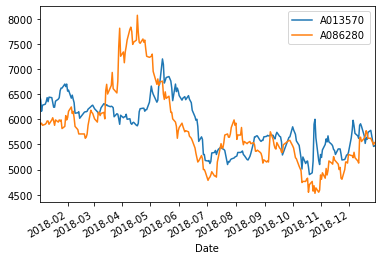

5th
1_1
2.4416235976245517e-05
R2: 0.9942601430896574


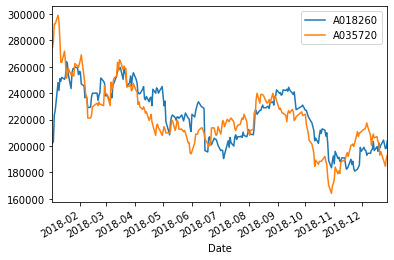

6th
1_1
6.238319848886247e-05
R2: 0.9960882153016622


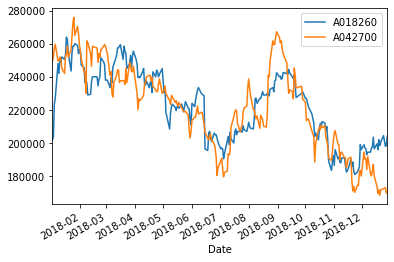

7th
1_1
0.002468525394533226
R2: 0.9916186932269611


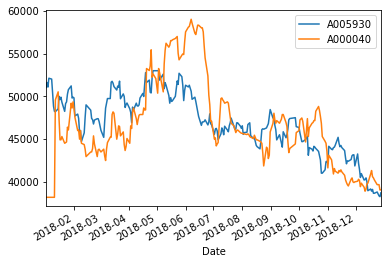

8th
1_1
0.005558520392096734
R2: 0.9962767965381497


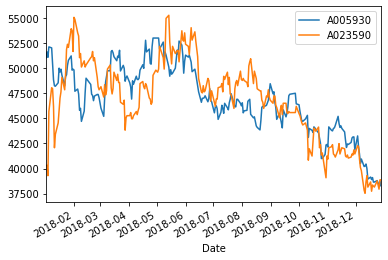

9th
1_1
0.006558796295376572
R2: 0.9897395242174736


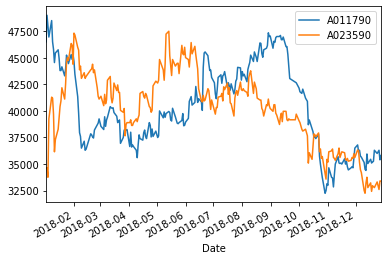

10th
2_1
0.0021926962479271984
R2: 0.997521523469459


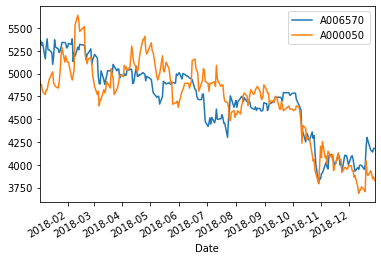

11th
2_0
8.996111882547869e-05
R2: 0.995238277030779


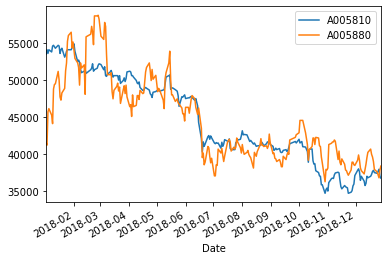

12th
2_0
0.010689833996171145
R2: 0.9906112115976945


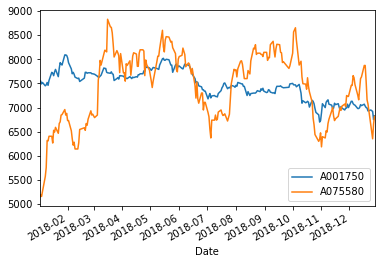

13th
2_0
0.011520559838808571
R2: 0.9936699241015051


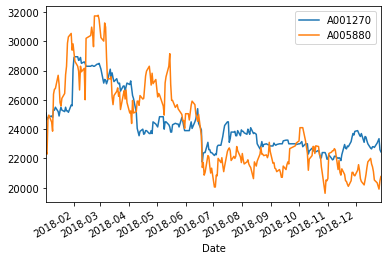

14th
3_1
0.012185838246664618
R2: 0.9963007081705765


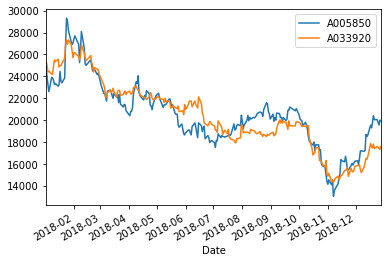

15th
3_0
0.019323103920393096
R2: 0.9904461983958119


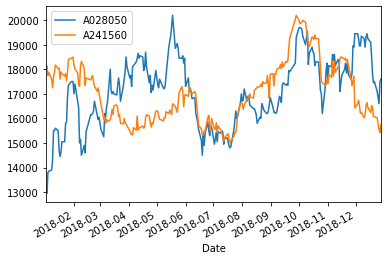

16th
4_4
0.0033470560718507855
R2: 0.9830568843005433


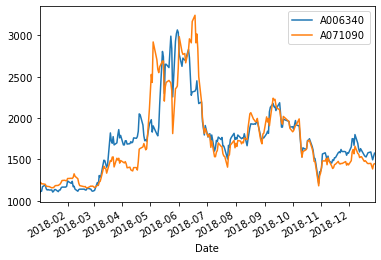

17th
4_0
0.0013978127299872994
R2: 0.9939741020239774


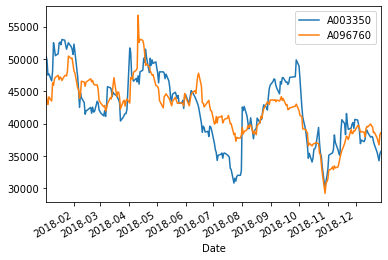

18th
4_0
0.0014770847165182404
R2: 0.9955830514984848


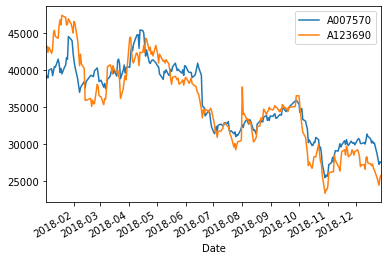

19th
4_0
0.0037682875825404715
R2: 0.9947350162559428


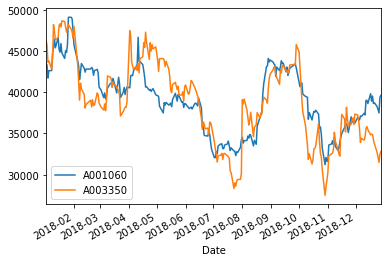

20th
4_0
0.008898753729825511
R2: 0.9929194166794232


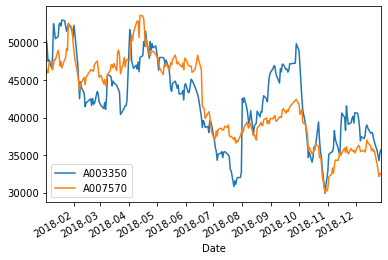

21th
5_2
8.211903119844428e-06
R2: 0.9925049410412793


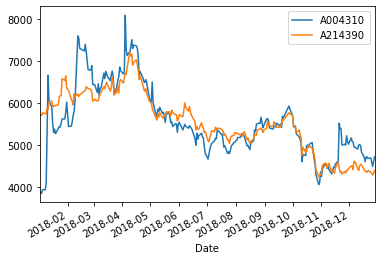

22th
5_2
6.840668119919373e-05
R2: 0.9872860742203192


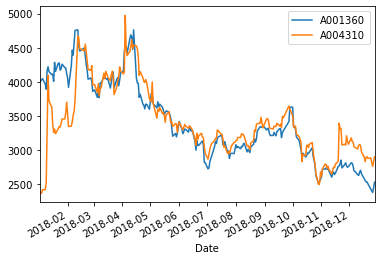

23th
5_2
6.868005591452151e-05
R2: 0.986580409435701


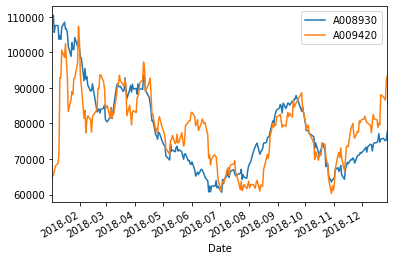

24th
5_2
0.00023473587972190122
R2: 0.9912138370877748


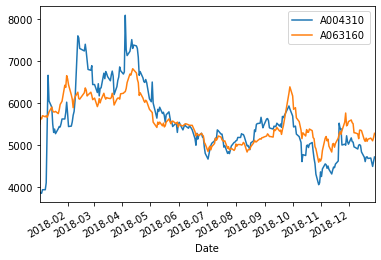

25th
5_2
0.00029005755410018173
R2: 0.9918712786961439


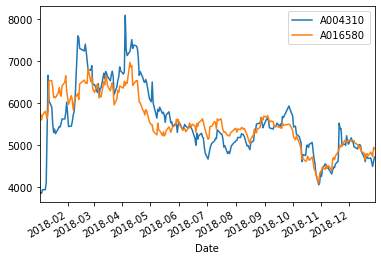

26th
6_0
0.0017320767026616796
R2: 0.9968943320490264


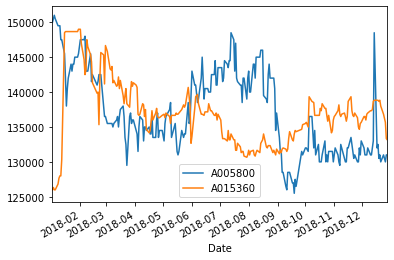

27th
6_0
0.0027211682452819115
R2: 0.9969721949959027


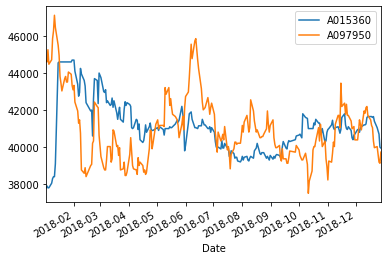

28th
6_0
0.00535158482456568
R2: 0.9808657681542066


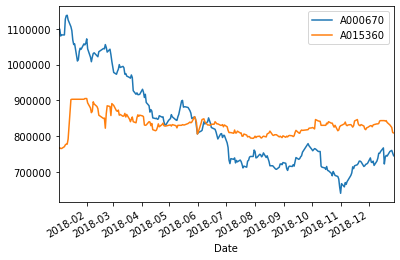

29th
6_0
0.005811335580973567
R2: 0.9972098113017152


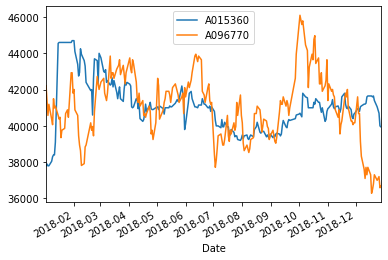

30th
6_0
0.011133031025043622
R2: 0.9980472287725995


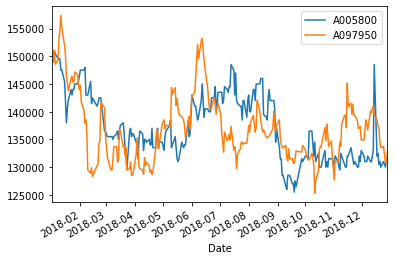

31th
7_0
5.523678954134555e-06
R2: 0.9988532505012457


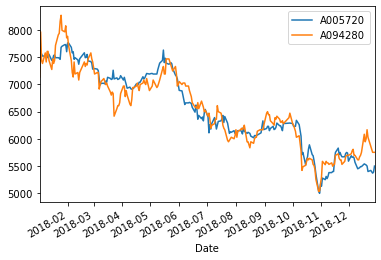

32th
7_0
1.5962374052310424e-05
R2: 0.9966143480792664


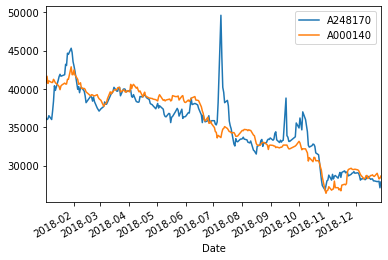

33th
7_0
2.49348364230638e-05
R2: 0.9969747592033126


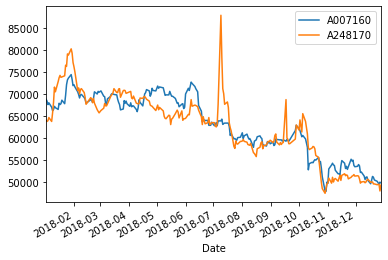

34th
7_0
0.00022894665690996856
R2: 0.9991401858894291


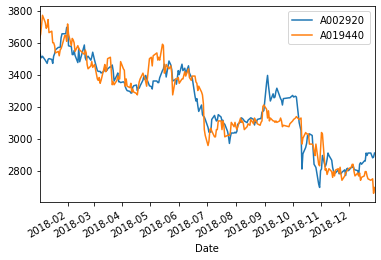

35th
7_0
0.00038135683322514054
R2: 0.9949966312477664


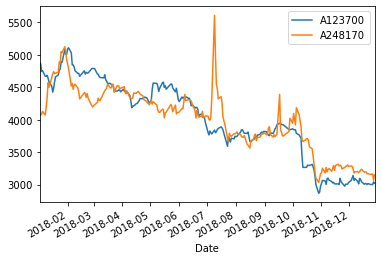

36th
8_0
7.714379718007977e-06
R2: 0.99619831188682


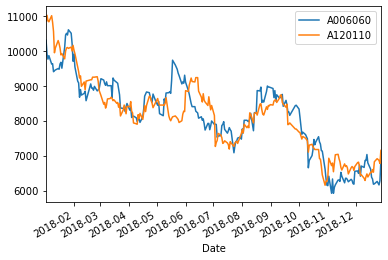

37th
8_0
2.3200899482753917e-05
R2: 0.9873456408795338


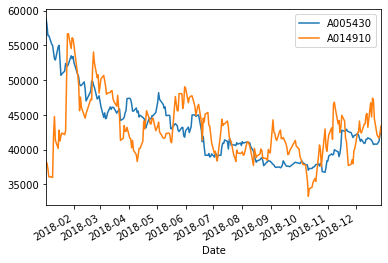

38th
8_0
2.3521798185105427e-05
R2: 0.9903300687541317


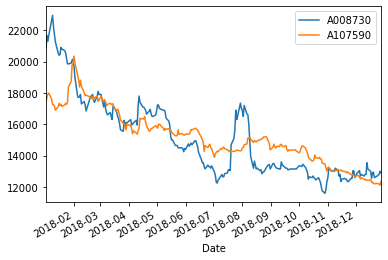

39th
8_0
2.8519655536140906e-05
R2: 0.9931072909259335


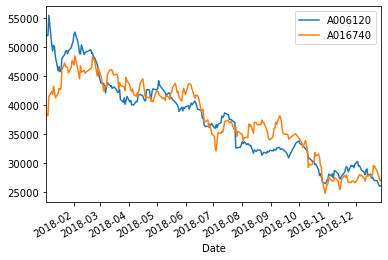

40th
8_0
9.402352472885405e-05
R2: 0.9751739224305945


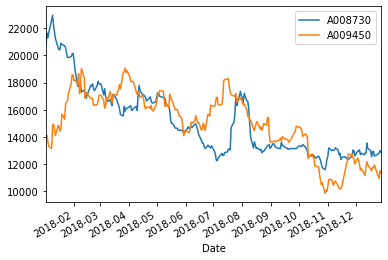

41th
9_1
0.00023954360825332276
R2: 0.9991471588470884


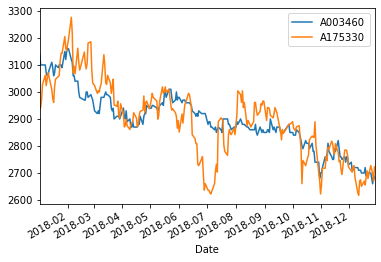

42th
9_1
0.0004643820951267999
R2: 0.9975361942805684


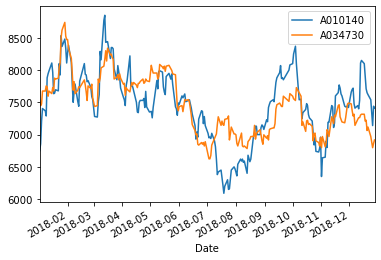

43th
9_1
0.0007030515917855821
R2: 0.9978311191185916


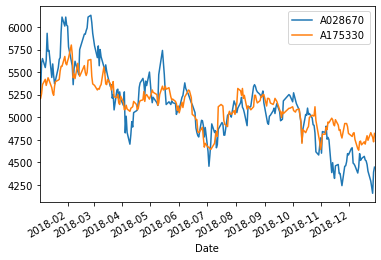

44th
9_1
0.0014073785442984407
R2: 0.9980099218096017


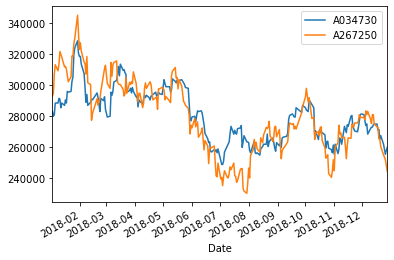

45th
9_1
0.0025209729607979523
R2: 0.9815601614033611


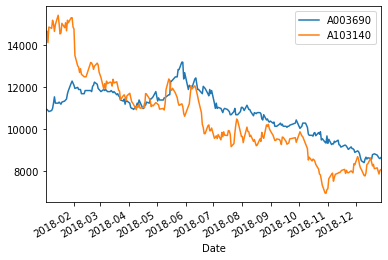

In [20]:
draw_pairs(df_pairs_t, formation_close)

In [24]:
l = []
for i in df_pairs_t.index:
    s1 = df_pairs_t.loc[i, 's1']
    s2 = df_pairs_t.loc[i, 's2']
    b = df_pairs_t.loc[i, 'beta']
    p1 = np.log(trading_close[s1])
    p2 = np.log(trading_close[s2])
    
    cpval = adfuller(p1 - b*p2)[1]
    l.append((s1, s2, cpval))

temp = pd.DataFrame(l, columns=['s1', 's2', 'pval'])  
print((temp['pval'] < 0.1).mean())
temp

0.2391304347826087


,s1,s2,pval
0,A001120,A204320,0.0644
1,A139480,A204320,0.0833
2,A026960,A072710,0.0579
3,A004000,A204320,0.5180
4,A013570,A086280,0.2407
5,A018260,A035720,0.9149
6,A018260,A042700,0.4029
7,A005930,A000040,0.2566
8,A005930,A023590,0.0111
9,A011790,A023590,0.1642


## Back Testing

In [25]:
i = 0
s1 = df_pairs_t.loc[i, 's1']
s2 = df_pairs_t.loc[i, 's2']

b = df_pairs_t.loc[i, 'beta']


In [26]:
trading_close

Symbol,A000020,A000040,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,...,A267290,A268280,A271560,A271980,A272450,A272550,A280360,A281820,A282330,A282690
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,9340.0000,2030.0000,10950.0000,21350.0000,78200.0000,16300.0000,40016.0000,166500.0000,7030.0000,82318.0000,...,26585.0000,64100.0000,111000.0000,44400.0000,19000.0000,17950.0000,153000.0000,9470.0000,205500.0000,12700.0000
2019-01-03,9170.0000,2042.0000,11150.0000,20900.0000,77200.0000,16200.0000,39346.0000,163000.0000,7020.0000,79561.0000,...,26585.0000,64600.0000,118000.0000,44250.0000,18550.0000,18300.0000,156500.0000,9170.0000,209500.0000,12900.0000
2019-01-04,9530.0000,2042.0000,11000.0000,21700.0000,79700.0000,16850.0000,42122.0000,163500.0000,7020.0000,78774.0000,...,26585.0000,64800.0000,121500.0000,52300.0000,18200.0000,18800.0000,162500.0000,9090.0000,214000.0000,12750.0000
2019-01-07,9530.0000,2046.0000,11100.0000,22000.0000,82100.0000,16750.0000,43654.0000,162000.0000,7390.0000,81137.0000,...,26305.0000,65300.0000,122500.0000,50800.0000,18250.0000,18650.0000,169500.0000,9470.0000,207500.0000,12900.0000
2019-01-08,9520.0000,2058.0000,11000.0000,22450.0000,81000.0000,16600.0000,44037.0000,161500.0000,7680.0000,81925.0000,...,26425.0000,64700.0000,123000.0000,48300.0000,18200.0000,18650.0000,164500.0000,9750.0000,205500.0000,12800.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,9880.0000,2127.0000,10500.0000,21050.0000,75000.0000,20700.0000,47579.0000,153000.0000,9160.0000,80743.0000,...,24983.0000,76500.0000,91200.0000,39000.0000,22450.0000,17550.0000,172000.0000,14800.0000,198000.0000,13350.0000
2019-06-25,9860.0000,2164.0000,10550.0000,20600.0000,74000.0000,21000.0000,46717.0000,144500.0000,9250.0000,81137.0000,...,24583.0000,76900.0000,92100.0000,39100.0000,21550.0000,17550.0000,174000.0000,14750.0000,192000.0000,13450.0000
2019-06-26,9840.0000,2201.0000,10500.0000,20650.0000,73400.0000,20850.0000,47291.0000,133000.0000,9240.0000,79955.0000,...,24583.0000,77900.0000,91500.0000,38700.0000,20950.0000,17550.0000,174500.0000,15200.0000,194000.0000,13550.0000


0th
0_2
0.0001595379318461604
R2: 0.9925312993787521


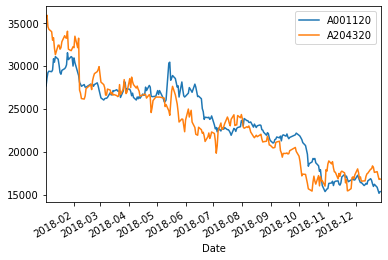

1th
0_2
0.00108707139395254
R2: 0.9868544179250036


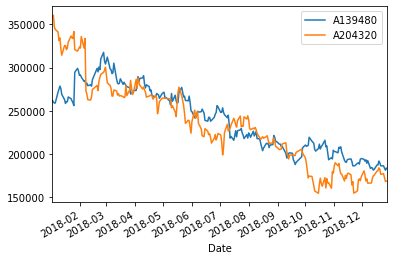

2th
0_2
0.001639852325484842
R2: 0.9987018288858769


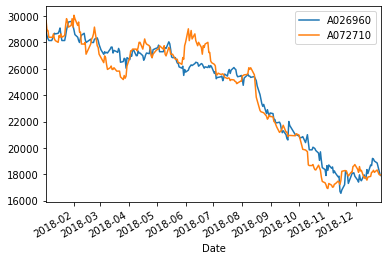

3th
0_2
0.00356745651597601
R2: 0.9871566362513677


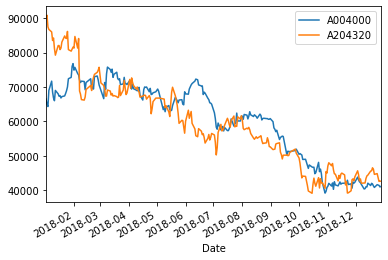

4th
0_2
0.009607186336737523
R2: 0.9883548598160425


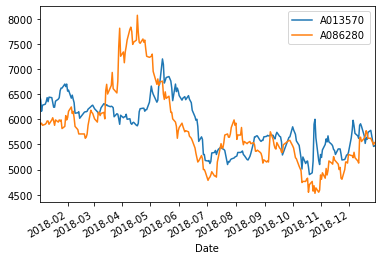

5th
1_1
2.4416235976245517e-05
R2: 0.9942601430896574


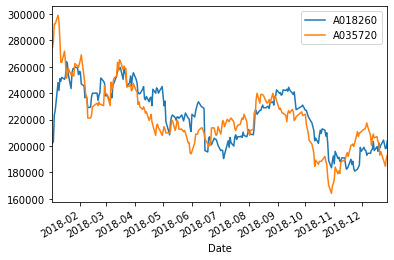

6th
1_1
6.238319848886247e-05
R2: 0.9960882153016622


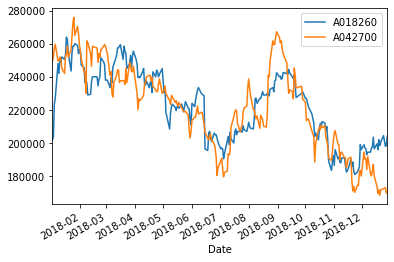

7th
1_1
0.002468525394533226
R2: 0.9916186932269611


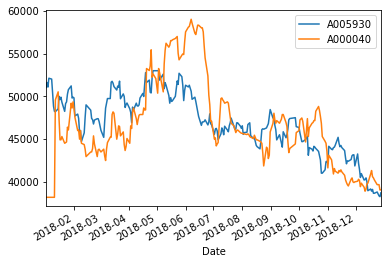

8th
1_1
0.005558520392096734
R2: 0.9962767965381497


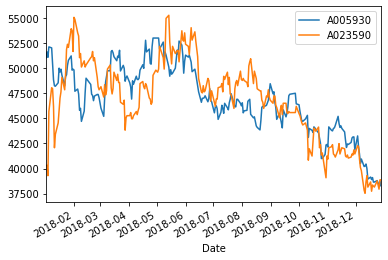

9th
1_1
0.006558796295376572
R2: 0.9897395242174736


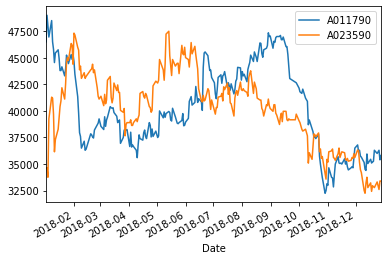

10th
2_1
0.0021926962479271984
R2: 0.997521523469459


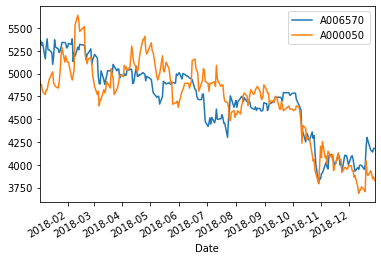

11th
2_0
8.996111882547869e-05
R2: 0.995238277030779


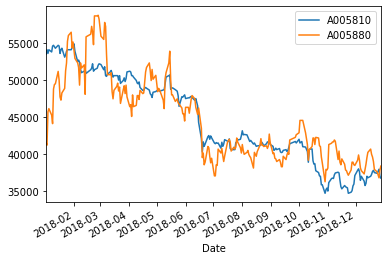

12th
2_0
0.010689833996171145
R2: 0.9906112115976945


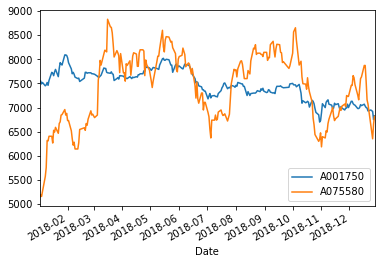

13th
2_0
0.011520559838808571
R2: 0.9936699241015051


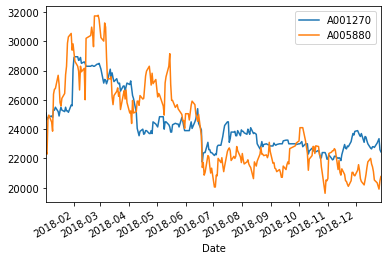

14th
3_1
0.012185838246664618
R2: 0.9963007081705765


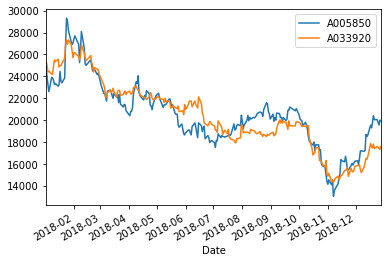

15th
3_0
0.019323103920393096
R2: 0.9904461983958119


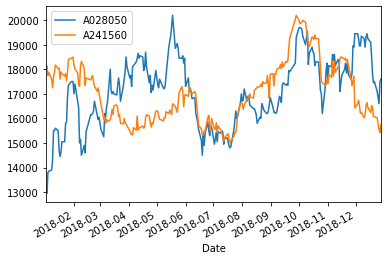

16th
4_4
0.0033470560718507855
R2: 0.9830568843005433


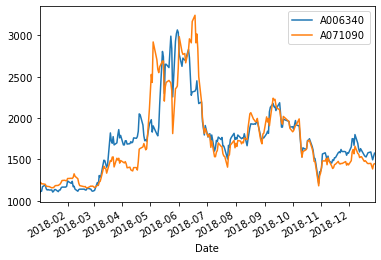

17th
4_0
0.0013978127299872994
R2: 0.9939741020239774


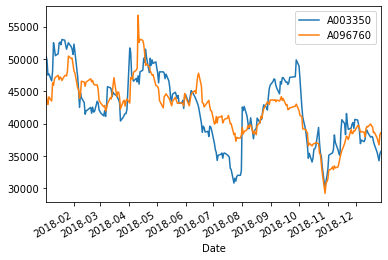

18th
4_0
0.0014770847165182404
R2: 0.9955830514984848


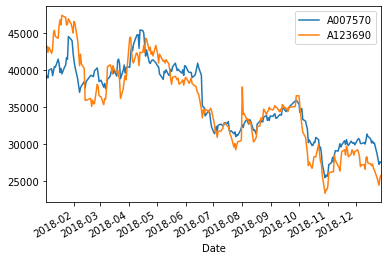

19th
4_0
0.0037682875825404715
R2: 0.9947350162559428


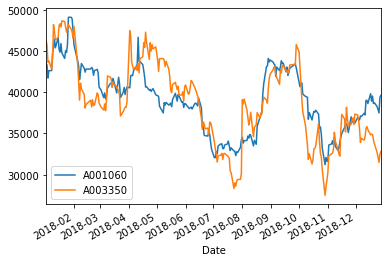

20th
4_0
0.008898753729825511
R2: 0.9929194166794232


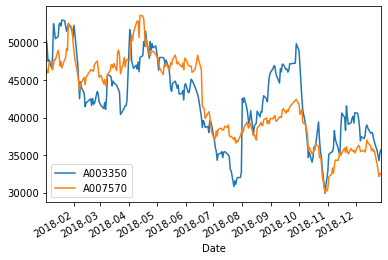

21th
5_2
8.211903119844428e-06
R2: 0.9925049410412793


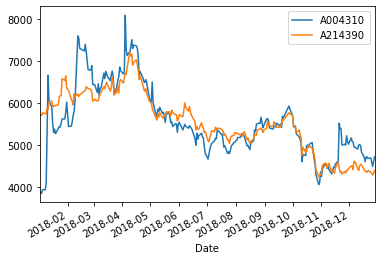

22th
5_2
6.840668119919373e-05
R2: 0.9872860742203192


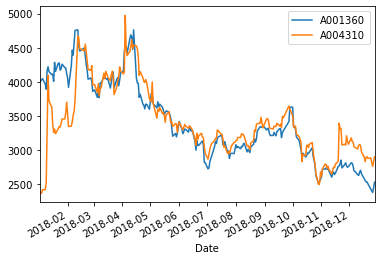

23th
5_2
6.868005591452151e-05
R2: 0.986580409435701


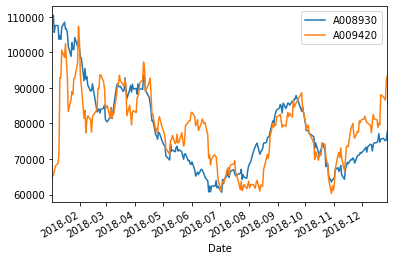

24th
5_2
0.00023473587972190122
R2: 0.9912138370877748


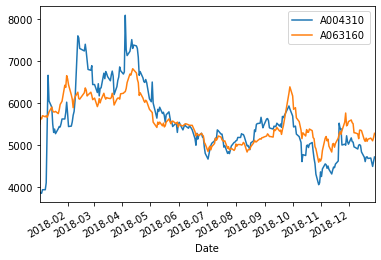

25th
5_2
0.00029005755410018173
R2: 0.9918712786961439


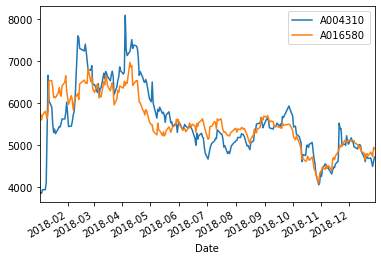

26th
6_0
0.0017320767026616796
R2: 0.9968943320490264


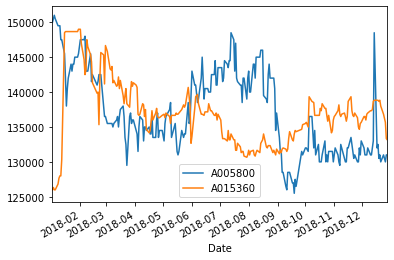

27th
6_0
0.0027211682452819115
R2: 0.9969721949959027


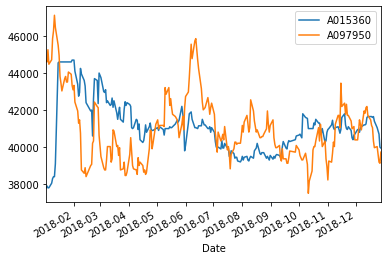

28th
6_0
0.00535158482456568
R2: 0.9808657681542066


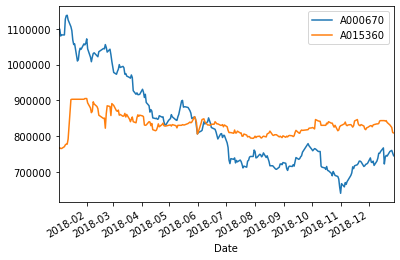

29th
6_0
0.005811335580973567
R2: 0.9972098113017152


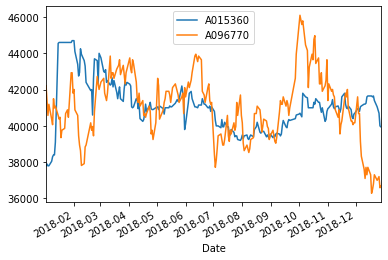

30th
6_0
0.011133031025043622
R2: 0.9980472287725995


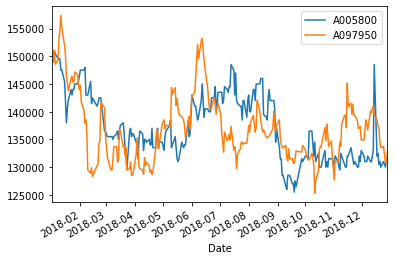

31th
7_0
5.523678954134555e-06
R2: 0.9988532505012457


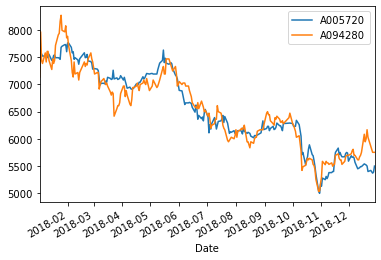

32th
7_0
1.5962374052310424e-05
R2: 0.9966143480792664


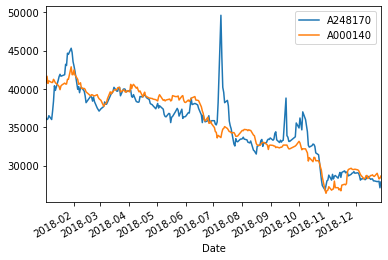

33th
7_0
2.49348364230638e-05
R2: 0.9969747592033126


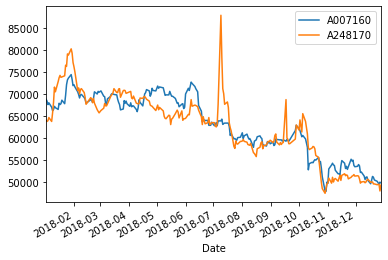

34th
7_0
0.00022894665690996856
R2: 0.9991401858894291


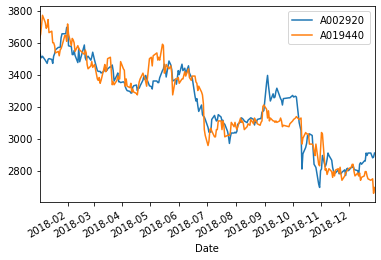

35th
7_0
0.00038135683322514054
R2: 0.9949966312477664


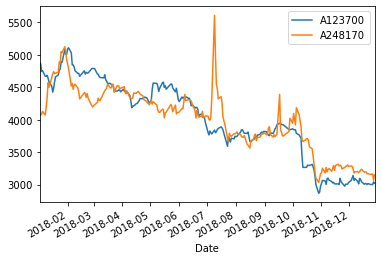

36th
8_0
7.714379718007977e-06
R2: 0.99619831188682


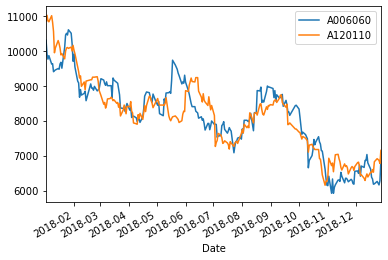

37th
8_0
2.3200899482753917e-05
R2: 0.9873456408795338


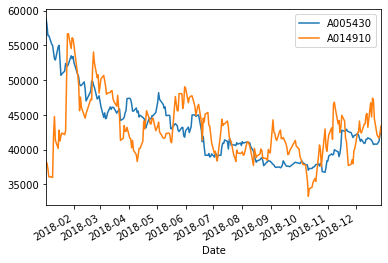

38th
8_0
2.3521798185105427e-05
R2: 0.9903300687541317


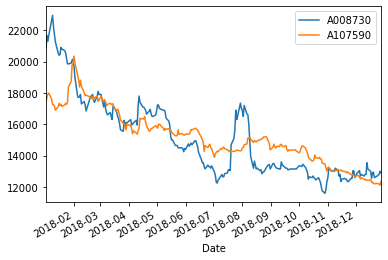

39th
8_0
2.8519655536140906e-05
R2: 0.9931072909259335


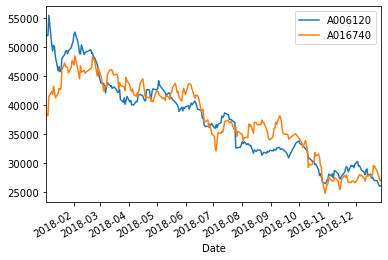

40th
8_0
9.402352472885405e-05
R2: 0.9751739224305945


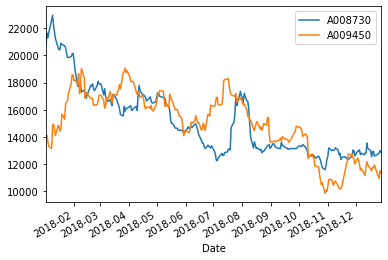

41th
9_1
0.00023954360825332276
R2: 0.9991471588470884


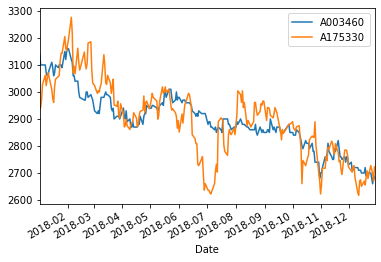

42th
9_1
0.0004643820951267999
R2: 0.9975361942805684


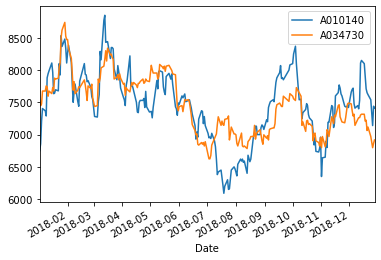

43th
9_1
0.0007030515917855821
R2: 0.9978311191185916


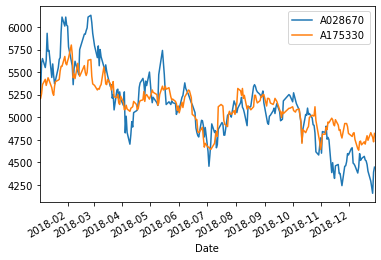

44th
9_1
0.0014073785442984407
R2: 0.9980099218096017


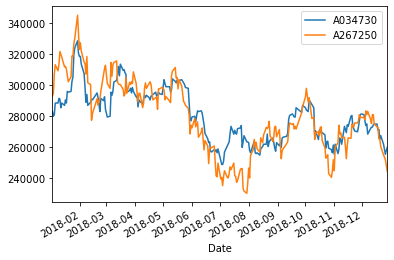

45th
9_1
0.0025209729607979523
R2: 0.9815601614033611


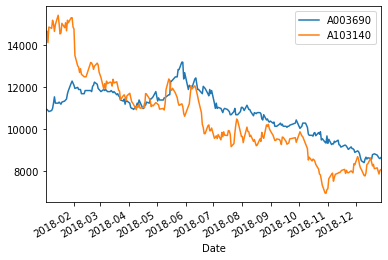

In [27]:
draw_pairs(df_pairs_t, formation_close)

In [36]:
sd_weight = {
    'Close': 0.5,
    'Open': 1.5,
    'Loss Cut': 4
}
def set_status(spread, mu, std):
    if spread > mu + std * sd_weight['Loss Cut']:
        return 1
    elif spread > mu + std * sd_weight['Open']:
        return 2
    elif spread > mu + std * sd_weight['Close']:
        return 3
    elif spread > mu - std * sd_weight['Close'] and spread < mu + std * sd_weight['Close']:
        return 4
    elif spread > mu - std * sd_weight['Open']:
        return 5
    elif spread > mu - std * sd_weight['Loss Cut']:
        return 6
    else:
        return 7

In [29]:
def get_pair_returns_ori(pair_info, formation_close, trading_close):
    position_count=0
    # i = 5
    pair1 = pair_info['s1']
    pair2 = pair_info['s2']
    beta = pair_info['beta']
    alpha = pair_info['alpha']

    ## Get Data
    formation = formation_close.loc[:, [pair1, pair2]]
    trading = trading_close.loc[:, [pair1, pair2]]
    
    # Formation Period Spread
    fspread = formation[pair1] - (formation[pair2]*beta + alpha)
    fspread_mu = np.mean(fspread)
    fspread_sd = np.std(fspread)

    # Trading Period Spread
    tspread = trading[pair1] - (trading[pair2]*beta + alpha)
    trading['spread'] = (tspread - fspread_mu)/fspread_sd
    trading['status'] = trading.apply(lambda x: set_status(x['spread'], 0, 1), axis=1)

    # trading['spread_ret'] = trading['stock'].pct_change().fillna(0)
    trading['pair1_ret'] = trading[pair1].pct_change().fillna(0)
    trading['pair2_ret'] = (trading[pair2]*beta + alpha).pct_change().fillna(0)
    trading['pair1_p'] = trading[pair1]
    trading['pair2_p'] = trading[pair2]*beta + alpha
    
    # trading['weighted_asset'] = (trading['pairA_ret'] * weightA + trading['pairB_ret'] * weightB) / (np.abs(weightA) + np.abs(weightB))
    trading['portfolio_ret'] = 0.5*(trading['pair1_ret']-trading['pair2_ret'])
    trading['position'] = None
    trading['ml_position'] = None
    trading['dollar_neutral'] = 1    
    # trading['pred'] = y_pred

    weighted_asset = 1.0
    equal_asset = 1.0

    # Set Position
    for i in range(1,len(trading)):
        prev_status = trading['status'][i-1]
        now_status = trading['status'][i]
        prev_position = trading['position'][i-1]

        if now_status == 1:
            trading['position'][i] = None
            break
        if now_status == 2:
            # trading['position'][i] = 'short' if trading['pred'][i] == 0 else None
            if (prev_status == 3) or (prev_position=='short'):
                trading['position'][i] = 'short'
        if now_status == 3:
            if prev_position == 'short':
                trading['position'][i] = 'short'
        if now_status == 4:
            trading['position'][i] = None
        if now_status == 5:
            if prev_position == 'long':
                trading['position'][i] = 'long'
        if now_status == 6:
            # trading['a'] = (prev_status == 5) || (prev_position=='long')
            if (prev_status == 5) or (prev_position=='long'):
                trading['position'][i] = 'long'# if trading['pred'][i] == 1 else None
        if now_status == 7:
            trading['position'][i] = None  # Original project was short
            break

    trading.loc[(trading['position'] == 'short') | (trading['position'].shift() == 'short'), 'position'] = 'short'
    trading.loc[(trading['position'] == 'long') | (trading['position'].shift() == 'long'), 'position'] = 'long'
    
    long_index = (trading['position'] == 'long')
    short_index = (trading['position'] == 'short')
    
    # Dollar Neutral Returns
    trading['dollar_neutral'][long_index] += trading['portfolio_ret'][long_index]
    trading['dollar_neutral'][short_index] -= trading['portfolio_ret'][short_index]
    trading['dollar_neutral'] = trading['dollar_neutral'].cumprod()
    
    # Quantity Neutral Returns
    trading['quantity_neutral'] = 1
    
    open_idx = long_index | short_index
    trading['count'] = 0
    trading.loc[(open_idx - open_idx.shift()) == 1, 'count'] = ((open_idx - open_idx.shift()) == 1).cumsum()
    trading.loc[(open_idx == True) & (trading['count'] == 0), 'count'] = np.nan
    trading['count'] = trading['count'].fillna(method=b'ffill')
    
    for c in trading['count'].unique()[1:]:
        temp_trading = trading.loc[trading['count'] == c, :]
        """
        qn_return = \
            (temp_trading[pair1][-1] - temp_trading[pair1][0] - ((temp_trading[pair2][-1] - temp_trading[pair2][0])*beta + alpha))\
            / (temp_trading[pair1][0] + temp_trading[pair2][0])
        """
        """
        for ti in temp_trading.index:
            qn_return = \
            (temp_trading['pair1_p'][ti] - temp_trading['pair1_p'][0] - (temp_trading['pair2_p'][ti] - temp_trading['pair2_p'][0]))\
            / (temp_trading['pair1_p'][0] + temp_trading['pair2_p'][0])
            if temp_trading['position'][0] == 'long':
                trading.loc[ti, 'quantity_neutral'] = qn_return + 1
            elif temp_trading['position'][0] == 'short':
                trading.loc[ti, 'quantity_neutral'] = -qn_return + 1
        """
        qn_return = \
            (temp_trading['pair1_p'][-1] - temp_trading['pair1_p'][0] - (temp_trading['pair2_p'][-1] - temp_trading['pair2_p'][0]))\
            / (temp_trading['pair1_p'][0] + temp_trading['pair2_p'][0])
        if temp_trading['position'][0] == 'long':
            trading.loc[temp_trading.index[-1], 'quantity_neutral'] = qn_return + 1
        elif temp_trading['position'][0] == 'short':
            trading.loc[temp_trading.index[-1], 'quantity_neutral'] = -qn_return + 1
        
    trading['quantity_neutral'] = trading['quantity_neutral'].cumprod()            
    
    # ret_list.append(trading['returns'])
    
    for j in range(1,len(trading)):
        if trading['position'][j-1] == None and trading['position'][j] != None:
            position_count += 1
    return trading, position_count

In [30]:
def get_pair_returns(pair_info, formation_close, trading_close):
    position_count=0
    # i = 5
    pair1 = pair_info['s1']
    pair2 = pair_info['s2']
    beta = pair_info['beta']
    alpha = pair_info['alpha']

    ## Get Data
    formation = formation_close.loc[:, [pair1, pair2]]
    trading = trading_close.loc[:, [pair1, pair2]]
    
    # Formation Period Spread
    fspread = formation[pair1] - (formation[pair2]*beta + alpha)
    fspread_mu = np.mean(fspread)
    fspread_sd = np.std(fspread)

    # Trading Period Spread
    tspread = trading[pair1] - (trading[pair2]*beta + alpha)
    trading['spread'] = (tspread - fspread_mu)/fspread_sd
    trading['status'] = trading.apply(lambda x: set_status(x['spread'], 0, 1), axis=1)

    # trading['spread_ret'] = trading['stock'].pct_change().fillna(0)
    trading['pair1_ret'] = trading[pair1].pct_change().fillna(0)
    trading['pair2_ret'] = (trading[pair2]*beta + alpha).pct_change().fillna(0)
    trading['pair1_p'] = trading[pair1]
    trading['pair2_p'] = trading[pair2]*beta + alpha
    
    # trading['weighted_asset'] = (trading['pairA_ret'] * weightA + trading['pairB_ret'] * weightB) / (np.abs(weightA) + np.abs(weightB))
    trading['portfolio_ret'] = 0.5*(trading['pair1_ret']-trading['pair2_ret'])
    trading['position'] = None
    trading['ml_position'] = None
    trading['dollar_neutral'] = 1    
    # trading['pred'] = y_pred

    weighted_asset = 1.0
    equal_asset = 1.0

    # Set Position
    for i in range(1,len(trading)):
        prev_status = trading['status'][i-1]
        now_status = trading['status'][i]
        prev_position = trading['position'][i-1]

        if now_status == 1:
            trading['position'][i] = None
            break
        if now_status == 2:
            # trading['position'][i] = 'short' if trading['pred'][i] == 0 else None
            if (prev_status == 3) or (prev_position=='short'):
                trading['position'][i] = 'short'
        if now_status == 3:
            if prev_position == 'short':
                trading['position'][i] = 'short'
        if now_status == 4:
            trading['position'][i] = None
        if now_status == 5:
            if prev_position == 'long':
                trading['position'][i] = 'long'
        if now_status == 6:
            # trading['a'] = (prev_status == 5) || (prev_position=='long')
            if (prev_status == 5) or (prev_position=='long'):
                trading['position'][i] = 'long'# if trading['pred'][i] == 1 else None
        if now_status == 7:
            trading['position'][i] = None  # Original project was short
            break

    trading.loc[(trading['position'] == 'short') | (trading['position'].shift() == 'short'), 'position'] = 'short'
    trading.loc[(trading['position'] == 'long') | (trading['position'].shift() == 'long'), 'position'] = 'long'
    
    long_index = (trading['position'] == 'long')
    short_index = (trading['position'] == 'short')
    
    # Dollar Neutral Returns
    trading['dollar_neutral'][long_index] += trading['portfolio_ret'][long_index]
    trading['dollar_neutral'][short_index] -= trading['portfolio_ret'][short_index]
    trading['dollar_neutral'] = trading['dollar_neutral'].cumprod()
    
    # Quantity Neutral Returns
    trading['quantity_neutral'] = 1
    
    open_idx = long_index | short_index
    trading['count'] = 0
    trading.loc[(open_idx - open_idx.shift()) == 1, 'count'] = ((open_idx - open_idx.shift()) == 1).cumsum()
    trading.loc[(open_idx == True) & (trading['count'] == 0), 'count'] = np.nan
    trading['count'] = trading['count'].fillna(method='ffill')
    trading['pv'] = 0
    
    for c in trading['count'].unique()[1:]:
        temp_trading = trading.loc[trading['count'] == c, :]
        # Initial value is margin of each pair's investment
        margin = (temp_trading['pair1_p'][0] + temp_trading['pair2_p']) * 0.5
        trading.loc[temp_trading.index[0], 'pv'] =  0 # 
        for t in range(1, len(temp_trading.index)):
            now_index = temp_trading.index[t]
            prev_index = temp_trading.index[t-1]
            pv = (temp_trading.loc[now_index, 'pair1_p'] - temp_trading.loc[prev_index, 'pair1_p'] -
                         (temp_trading.loc[now_index, 'pair2_p'] - temp_trading.loc[prev_index, 'pair2_p']))
            if temp_trading['position'][0] == 'long':
                trading.loc[now_index, 'pv'] = pv
            elif temp_trading['position'][0] == 'short':
                trading.loc[now_index, 'pv'] = -pv
        trading.loc[temp_trading.index, 'quantity_neutral'] = trading.loc[temp_trading.index, 'pv'].cumsum()
        trading.loc[temp_trading.index, 'quantity_neutral'] += margin
        trading.loc[temp_trading.index, 'quantity_neutral'] = trading.loc[temp_trading.index, 'quantity_neutral'].pct_change() + 1
        trading.loc[temp_trading.index[0], 'quantity_neutral'] = 1
            
        """
        qn_return = \
            (temp_trading[pair1][-1] - temp_trading[pair1][0] - ((temp_trading[pair2][-1] - temp_trading[pair2][0])*beta + alpha))\
            / (temp_trading[pair1][0] + temp_trading[pair2][0])
        """
        """
        for ti in temp_trading.index:
            qn_return = \
            (temp_trading['pair1_p'][ti] - temp_trading['pair1_p'][0] - (temp_trading['pair2_p'][ti] - temp_trading['pair2_p'][0]))\
            / (temp_trading['pair1_p'][0] + temp_trading['pair2_p'][0])
            if temp_trading['position'][0] == 'long':
                trading.loc[ti, 'quantity_neutral'] = qn_return + 1
            elif temp_trading['position'][0] == 'short':
                trading.loc[ti, 'quantity_neutral'] = -qn_return + 1
        """
        """
        qn_return = \
            (temp_trading['pair1_p'][-1] - temp_trading['pair1_p'][0] - (temp_trading['pair2_p'][-1] - temp_trading['pair2_p'][0]))\
            / (temp_trading['pair1_p'][0] + temp_trading['pair2_p'][0])
        if temp_trading['position'][0] == 'long':
            trading.loc[temp_trading.index[-1], 'quantity_neutral'] = qn_return + 1
        elif temp_trading['position'][0] == 'short':
            trading.loc[temp_trading.index[-1], 'quantity_neutral'] = -qn_return + 1
        """
        
    # trading['quantity_neutral'] = trading['quantity_neutral'].cumprod()            
    
    # ret_list.append(trading['returns'])
    
    for j in range(1,len(trading)):
        if trading['position'][j-1] == None and trading['position'][j] != None:
            position_count += 1
    return trading, position_count

In [39]:
def get_pair_returns_ml(pair_info, formation_close, trading_close):
    position_count=0
    # i = 5
    pair1 = pair_info['s1']
    pair2 = pair_info['s2']
    beta = pair_info['beta']
    alpha = pair_info['alpha']

    ## Get Data
    formation = formation_close.loc[:, [pair1, pair2]]
    trading = trading_close.loc[:, [pair1, pair2]]
    
    # Formation Period Spread
    fspread = formation[pair1] - (formation[pair2]*beta + alpha)
    fspread_mu = np.mean(fspread)
    fspread_sd = np.std(fspread)

    # Trading Period Spread
    tspread = trading[pair1] - (trading[pair2]*beta + alpha)
    trading['spread'] = (tspread - fspread_mu)/fspread_sd
    trading['status'] = trading.apply(lambda x: set_status(x['spread'], 0, 1), axis=1)

    # trading['spread_ret'] = trading['stock'].pct_change().fillna(0)
    trading['pair1_ret'] = trading[pair1].pct_change().fillna(0)
    trading['pair2_ret'] = (trading[pair2]*beta + alpha).pct_change().fillna(0)
    trading['pair1_p'] = trading[pair1]
    trading['pair2_p'] = trading[pair2]*beta + alpha
    
    # trading['weighted_asset'] = (trading['pairA_ret'] * weightA + trading['pairB_ret'] * weightB) / (np.abs(weightA) + np.abs(weightB))
    trading['portfolio_ret'] = 0.5*(trading['pair1_ret']-trading['pair2_ret'])
    trading['position'] = None
    trading['ml_position'] = None
    trading['dollar_neutral'] = 1    
    # trading['pred'] = y_pred

    weighted_asset = 1.0
    equal_asset = 1.0

    # Set Position
    for i in range(1,len(trading)):
        prev_status = trading['status'][i-1]
        now_status = trading['status'][i]
        prev_position = trading['position'][i-1]

        if now_status == 1:
            trading['position'][i] = None
            break
        if now_status == 2:
            # trading['position'][i] = 'short' if trading['pred'][i] == 0 else None
            if (prev_status == 3) or (prev_position=='short'):
                trading['position'][i] = 'short'
        if now_status == 3:
            if prev_position == 'short':
                trading['position'][i] = 'short'
        if now_status == 4:
            trading['position'][i] = None
        if now_status == 5:
            if prev_position == 'long':
                trading['position'][i] = 'long'
        if now_status == 6:
            # trading['a'] = (prev_status == 5) || (prev_position=='long')
            if (prev_status == 5) or (prev_position=='long'):
                trading['position'][i] = 'long'# if trading['pred'][i] == 1 else None
        if now_status == 7:
            trading['position'][i] = None  # Original project was short
            break

    trading.loc[(trading['position'] == 'short') | (trading['position'].shift() == 'short'), 'position'] = 'short'
    trading.loc[(trading['position'] == 'long') | (trading['position'].shift() == 'long'), 'position'] = 'long'
    
    long_index = (trading['position'] == 'long')
    short_index = (trading['position'] == 'short')
    
    # Dollar Neutral Returns
    trading['dollar_neutral'][long_index] += trading['portfolio_ret'][long_index]
    trading['dollar_neutral'][short_index] -= trading['portfolio_ret'][short_index]
    trading['dollar_neutral'] = trading['dollar_neutral'].cumprod()
    
    # Quantity Neutral Returns
    trading['quantity_neutral'] = 1
    
    open_idx = long_index | short_index
    trading['count'] = 0
    trading.loc[(open_idx - open_idx.shift()) == 1, 'count'] = ((open_idx - open_idx.shift()) == 1).cumsum()
    trading.loc[(open_idx == True) & (trading['count'] == 0), 'count'] = np.nan
    trading['count'] = trading['count'].fillna(method='ffill')
    trading['pv'] = 0
    
    for c in trading['count'].unique()[1:]:
        temp_trading = trading.loc[trading['count'] == c, :]
        # Initial value is margin of each pair's investment
        margin = (temp_trading['pair1_p'][0] + temp_trading['pair2_p']) * 0.5
        trading.loc[temp_trading.index[0], 'pv'] =  0 # 
        for t in range(1, len(temp_trading.index)):
            now_index = temp_trading.index[t]
            prev_index = temp_trading.index[t-1]
            pv = (temp_trading.loc[now_index, 'pair1_p'] - temp_trading.loc[prev_index, 'pair1_p'] -
                         (temp_trading.loc[now_index, 'pair2_p'] - temp_trading.loc[prev_index, 'pair2_p']))
            if temp_trading['position'][0] == 'long':
                trading.loc[now_index, 'pv'] = pv
            elif temp_trading['position'][0] == 'short':
                trading.loc[now_index, 'pv'] = -pv
        trading.loc[temp_trading.index, 'quantity_neutral'] = trading.loc[temp_trading.index, 'pv'].cumsum()
        trading.loc[temp_trading.index, 'quantity_neutral'] += margin
        trading.loc[temp_trading.index, 'quantity_neutral'] = trading.loc[temp_trading.index, 'quantity_neutral'].pct_change() + 1
        trading.loc[temp_trading.index[0], 'quantity_neutral'] = 1
            
        """
        qn_return = \
            (temp_trading[pair1][-1] - temp_trading[pair1][0] - ((temp_trading[pair2][-1] - temp_trading[pair2][0])*beta + alpha))\
            / (temp_trading[pair1][0] + temp_trading[pair2][0])
        """
        """
        for ti in temp_trading.index:
            qn_return = \
            (temp_trading['pair1_p'][ti] - temp_trading['pair1_p'][0] - (temp_trading['pair2_p'][ti] - temp_trading['pair2_p'][0]))\
            / (temp_trading['pair1_p'][0] + temp_trading['pair2_p'][0])
            if temp_trading['position'][0] == 'long':
                trading.loc[ti, 'quantity_neutral'] = qn_return + 1
            elif temp_trading['position'][0] == 'short':
                trading.loc[ti, 'quantity_neutral'] = -qn_return + 1
        """
        """
        qn_return = \
            (temp_trading['pair1_p'][-1] - temp_trading['pair1_p'][0] - (temp_trading['pair2_p'][-1] - temp_trading['pair2_p'][0]))\
            / (temp_trading['pair1_p'][0] + temp_trading['pair2_p'][0])
        if temp_trading['position'][0] == 'long':
            trading.loc[temp_trading.index[-1], 'quantity_neutral'] = qn_return + 1
        elif temp_trading['position'][0] == 'short':
            trading.loc[temp_trading.index[-1], 'quantity_neutral'] = -qn_return + 1
        """
        
    # trading['quantity_neutral'] = trading['quantity_neutral'].cumprod()            
    
    # ret_list.append(trading['returns'])
    
    for j in range(1,len(trading)):
        if trading['position'][j-1] == None and trading['position'][j] != None:
            position_count += 1
    return trading, position_count

In [37]:
ret_df = pd.DataFrame()
for i in range(len(df_pairs_t)):
    # print(i)
    a, c = get_pair_returns(df_pairs_t.loc[i, :], formation_close, trading_close)
    ret_df[i] = a['quantity_neutral']
    # ret_list.append(a['quantity_neutral'][-1])
ret_df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0000,1.0000,1.0000,1
2019-01-03,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0000,1.0000,1.0000,1
2019-01-04,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1,1.0000,0.9786,1.0000,1.0000,1
2019-01-07,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0276,1.0000,1.0000,1
2019-01-08,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1,1.0000,1.0482,1.0000,1.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,1.0000,0.9884,1.0000,1.0302,1.0082,0.9912,1,1.0000,1.0000,1.0000,...,1.0000,1.0000,0.9885,1.0876,1,1.0000,1.0000,1.0000,1.0000,1
2019-06-25,1.0000,0.9981,1.0000,0.9741,0.9770,0.9860,1,1.0000,1.0000,1.0000,...,1.0000,1.0000,0.9994,0.9917,1,1.0000,1.0000,1.0000,1.0000,1
2019-06-26,1.0000,0.9951,1.0000,1.0018,0.9837,1.0064,1,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0126,0.9997,1,1.0000,1.0000,1.0000,1.0000,1


In [191]:
class Statistics:
    def __init__(self, ret_df):
        self.ret_df = ret_df
        ret_list = ret_df.cumprod().iloc[-1, :]
        self.ret_mean = ret_list.mean()
        self.ret_std = ret_list.std()
        self.ret_skew = ret_list.skew()
        self.ret_kur = ret_list.kurtosis()
        self.ret_min = ret_list.min()
        self.ret_max = ret_list.max()
        self.roo = (ret_list > 1).sum()
        self.ruo = (ret_list < 1).sum()
        self.reo = (ret_list == 1).sum()
        rf = 0.02
        daily_ret = (ret_df-1).sum(axis=1)
        self.sharpe = sharpe_ratio(daily_ret, rf)
        
    def print_statistics(self):
        print("Date: {} ~ {}".format(self.ret_df.index[0], self.ret_df.index[-1]))
        print('# of Date: {}'.format(len(self.ret_df)))
        print('# of Pairs: {}'.format(len(self.ret_df.columns)))
        print('Mean: {:.4f}'.format(self.ret_mean))
        print('Standard Deviation: {:.4f}'.format(self.ret_std))
        print('Skewness: {:.4f}'.format(self.ret_skew))
        print('Kurtosis: {:.4f}'.format(self.ret_kur))
        print('Min: {:.4f}'.format(self.ret_min))
        print('Max: {:.4f}'.format(self.ret_max))
        print('Observation with Excess Return > 1: {}'.format(self.roo))
        print('Observation with Excess Return < 1: {}'.format(self.ruo))
        print('Observation with Excess Return = 1: {}'.format(self.reo))
        print('Sharpe Ratio: {:.4f}'.format(self.sharpe))

In [192]:
Statistics(ret_df).print_statistics()

Date: 2019-01-02 00:00:00 ~ 2019-06-28 00:00:00
# of Date: 121
# of Pairs: 46
Mean: 1.0262
Standard Deviation: 0.1030
Skewness: -0.0609
Kurtosis: 0.5319
Min: 0.7659
Max: 1.2610
Observation with Excess Return > 1: 24
Observation with Excess Return < 1: 14
Observation with Excess Return = 1: 8
Sharpe Ratio: 0.2999


In [163]:
def get_statistics(ret_df):
    ret_list = ret_df.cumprod().iloc[-1, :]
    ret_mean = ret_list.mean()
    ret_std = ret_list.std()
    ret_skew = ret_list.skew()
    ret_kur = ret_list.kurtosis()
    roo = (ret_list > 1).sum()
    ruo = (ret_list < 1).sum()
    reo = (ret_list == 1).sum()
    rf = 0.02
    s = sharpe_ratio(ret_df, rf)

    report_dict = {
        'Date': (ret_df.index[0], ret_df.index[-1]),
        '# of Date': len(ret_df),
        '# of Pairs': len(ret_df.columns),
        'Mean': ret_mean,
        'Standard Deviation': ret_std,
        'Skewness': ret_skew,
        'Kurtosis': ret_kur,
        'Observation with Excess Return > 1': roo,
        'Observation with Excess Return < 1': ruo,
        'Observation with Excess Return = 1': reo,
        #'Sharpe Ratio': s
    }
    
    return report_dict

In [166]:
pd.DataFrame(get_statistics(ret_df)).T

,0,1
Date,2019-01-02 00:00:00,2019-06-28 00:00:00
# of Date,121,121
# of Pairs,46,46
Mean,1.0262,1.0262
Standard Deviation,0.1030,0.1030
Skewness,-0.0609,-0.0609
Kurtosis,0.5319,0.5319
Observation with Excess Return > 1,24,24
Observation with Excess Return < 1,14,14
Observation with Excess Return = 1,8,8


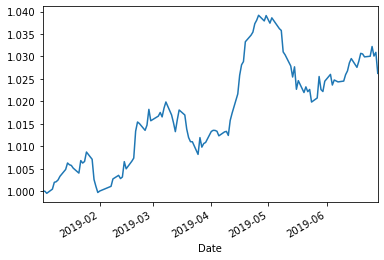

In [53]:
ret_df.cumprod().mean(axis=1).plot()

In [63]:
def sharpe_ratio(ret_series, rf_rate):
    yr1 = 252
    s = (ret_series.mean() - rf_rate*len(ret_series)/yr1) / ret_series.std()
    annual_s = s * np.sqrt(yr1)
    return annual_s    

In [64]:
rf = 0.02
sharpe_ratio(x, 0.02)

0.29989036425488197

In [80]:
x = ((ret_df-1).sum(axis=1))
(x.mean() -0.02*len(ret_df)/252) / x.std() * np.sqrt(252)

0.29989036425488197

Date
2019-01-02   1.0000
2019-01-03   1.0000
2019-01-04   1.0000
2019-01-07   1.0000
2019-01-08   1.0000
              ...  
2019-06-24   1.1300
2019-06-25   1.1300
2019-06-26   1.1300
2019-06-27   1.1300
2019-06-28   1.1300
Name: quantity_neutral, Length: 121, dtype: float64


C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\ipykernel_la

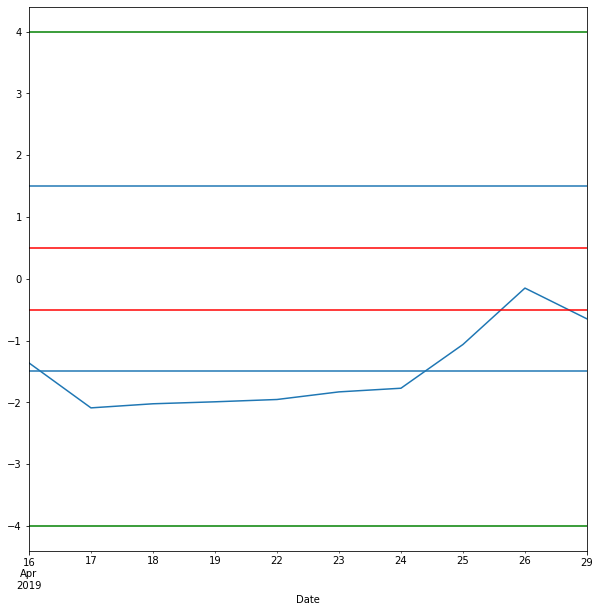

In [86]:
a, c = get_pair_returns1(df_pairs_t.loc[0, :], formation_close, trading_close)
print(a['quantity_neutral'].cumprod())
# print(a['dollar_neutral'][-1])

plt.figure(figsize=(10,10))
a['spread'][70:80].plot()

# [plt.axhline(y=x) for x in [0, 1.5, -1.5, 4, -4]]

plt.axhline(y=.5, color='r')
plt.axhline(y=-.5, color='r')
plt.axhline(y=1.5)
plt.axhline(y=-1.5)
plt.axhline(y=4, color='g')
plt.axhline(y=-4, color='g')

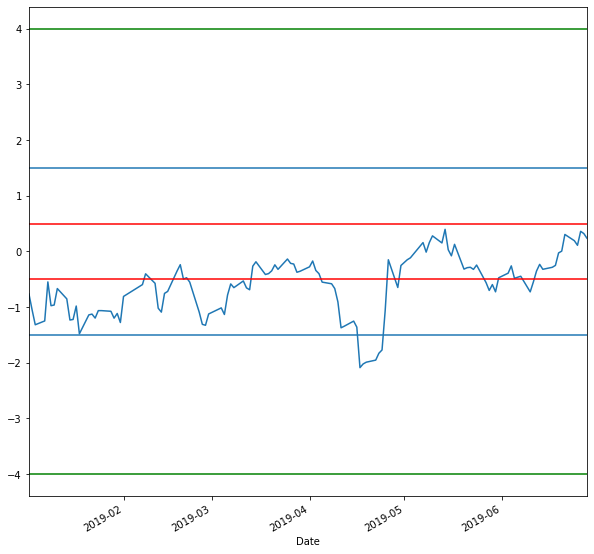

In [87]:
plt.figure(figsize=(10,10))
a['spread'].plot()

# [plt.axhline(y=x) for x in [0, 1.5, -1.5, 4, -4]]

plt.axhline(y=.5, color='r')
plt.axhline(y=-.5, color='r')
plt.axhline(y=1.5)
plt.axhline(y=-1.5)
plt.axhline(y=4, color='g')
plt.axhline(y=-4, color='g')